In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

from sklearn.metrics import mean_squared_error,mean_absolute_error

import warnings
warnings.filterwarnings('ignore')
import pprint

2.0.0


In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns',None)
np.random.seed(1234)

In [449]:
pwd

'C:\\Users\\jli\\Documents\\JLI\\Code & Examples\\UDEMY_TSA_FINAL'

### Load Data

In [70]:
sequence_data=pd.read_csv(r'C:\Users\jli\Documents\JLI\Code & Examples\python_for_time_series\UDEMY_TSA_FINAL\sequence_data.csv', parse_dates=True, index_col='Date')
sequence_data=sequence_data.head(794)

sequence_data['Volume']=sequence_data['Volume'].astype('float32')
# sequence_data.index=sequence_data['Date']
sequence_data.index.freq='D'

In [416]:
sequence_data.index

DatetimeIndex(['2008-01-01', '2008-01-02', '2008-01-03', '2008-01-04',
               '2008-01-05', '2008-01-06', '2008-01-07', '2008-01-08',
               '2008-01-09', '2008-01-10',
               ...
               '2010-02-23', '2010-02-24', '2010-02-25', '2010-02-26',
               '2010-02-27', '2010-02-28', '2010-03-01', '2010-03-02',
               '2010-03-03', '2010-03-04'],
              dtype='datetime64[ns]', name='Date', length=794, freq='D')

In [7]:
sequence_data.dtypes

Volume    float32
dtype: object

In [12]:
sequence_data.tail(10)

Volume
Date              
2010-02-23  1752.0
2010-02-24  1681.0
2010-02-25  1877.0
2010-02-26  1766.0
2010-02-27  1498.0
2010-02-28  1252.0
2010-03-01  1100.0
2010-03-02  1812.0
2010-03-03  1750.0
2010-03-04  1748.0

In [6]:
sequence_data['Volume'].isnull().sum()

0

### Visualize Time Series

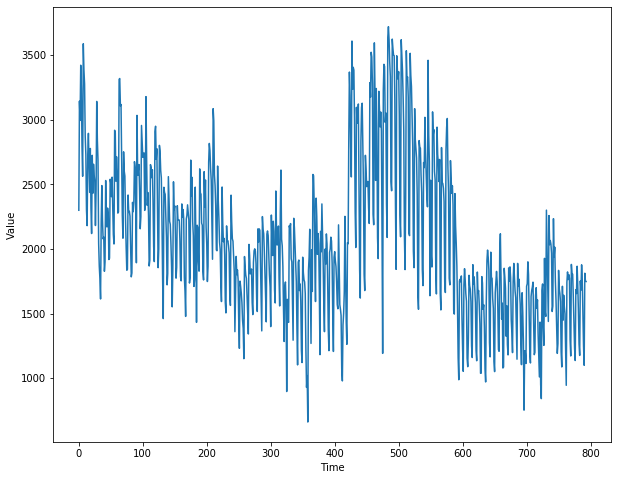

In [71]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.figure(figsize=(10,8))
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)
    
    
time = np.arange(0,794, dtype="float32")
series=np.array(sequence_data['Volume'])

split_time = 730 #update from 365 to 730
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 15
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [7]:
print(series.shape, time.shape)

(794,) (794,)


In [10]:
print(x_train.shape, time_train.shape, x_valid.shape, time_valid.shape)

(730,) (730,) (64,) (64,)


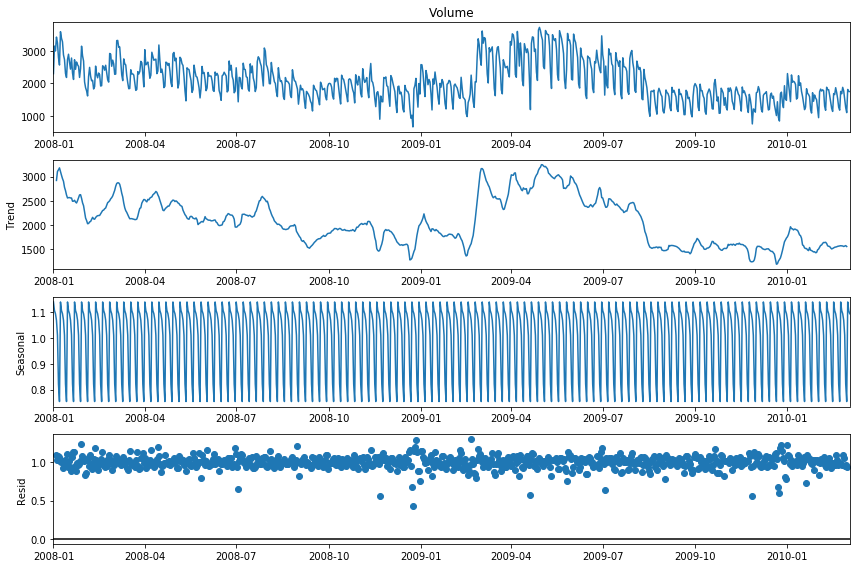

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
rcParams['figure.figsize']=12,8

result = seasonal_decompose(sequence_data['Volume'], model='multiplicative')  # model='mul' also works
result.plot();

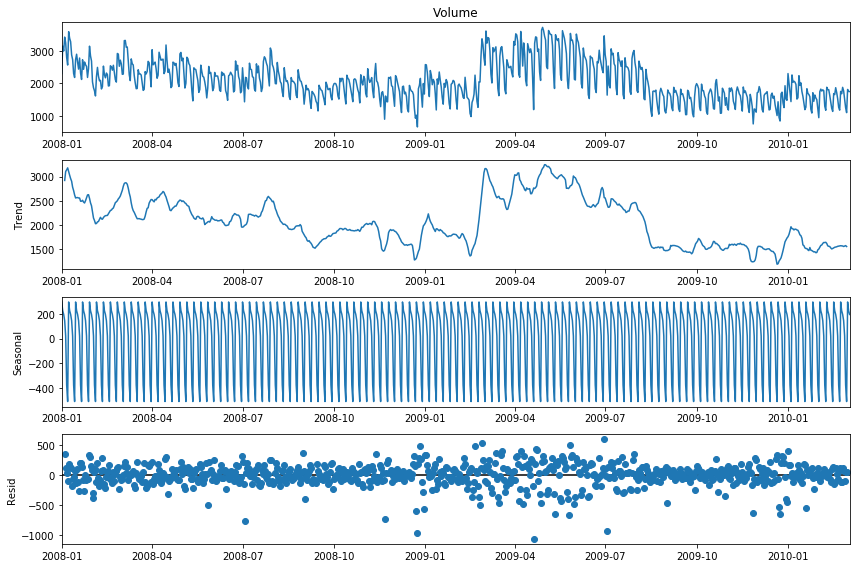

In [10]:
result = seasonal_decompose(sequence_data['Volume'], model='addictive')  # model='mul' also works
result.plot();

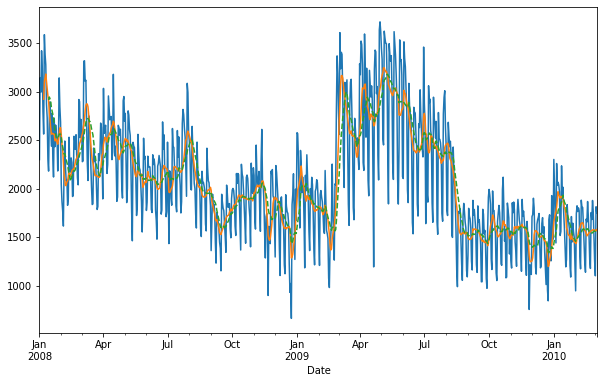

In [11]:
sequence_data['Volume'].plot(figsize=(12,6))
sequence_data['Volume'].rolling(window=7).mean().plot(figsize=(10,6))
sequence_data['Volume'].rolling(window=14).mean().plot(figsize=(10,6),  ls='--');

In [72]:
# create dataframes to be used by statmodels
x_train_df = sequence_data[:split_time]
x_valid_df = sequence_data[split_time:]

# Moving Average

  ### 1) Naive Forecast

use previous day actual to forecast the next day, below is naive forecast with numpy

In [13]:
naive_forecast = series[split_time - 1:-1]

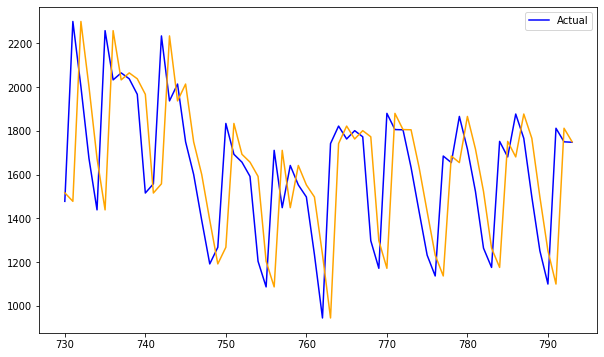

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(time_valid, x_valid, color='blue')

plt.legend(['Actual'])
# sequence_data['Volume'][split_time:].plot(legend=True, label='Actual')
ax2=plt.plot(time_valid, naive_forecast, color='orange')
# plt.legend(['Naive Forecast']);

In [15]:
# this is not a true forecast benchmark because the naive forecast using the previous day data to predict tomorrow's data
# this doesn't allow forecast a long period into the future
print(tf.keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

239.92188


In [16]:
review_naive_forecast=pd.DataFrame()

review_naive_forecast['Actual']=(x_valid).astype(int)
review_naive_forecast['NF']=(naive_forecast).astype(int)

review_naive_forecast.tail(10)

Actual    NF
54    1752  1176
55    1681  1752
56    1877  1681
57    1766  1877
58    1498  1766
59    1252  1498
60    1100  1252
61    1812  1100
62    1750  1812
63    1748  1750

#### pandas.dataframe.shift

In [76]:
x_valid_df['NF']=sequence_data.iloc[split_time-1:-1]['Volume'].shift(1)
x_valid_df[['Volume','NF']].tail(10)

Volume      NF
Date                      
2010-02-23  1752.0  1176.0
2010-02-24  1681.0  1752.0
2010-02-25  1877.0  1681.0
2010-02-26  1766.0  1877.0
2010-02-27  1498.0  1766.0
2010-02-28  1252.0  1498.0
2010-03-01  1100.0  1252.0
2010-03-02  1812.0  1100.0
2010-03-03  1750.0  1812.0
2010-03-04  1748.0     NaN

### 2) Simple Moving Average

numpy approach to generate moving average

In [17]:
# calculates moving average
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

In [18]:
moving_avg = moving_average_forecast(series, window_size)[split_time - window_size:]

len(moving_avg)

64

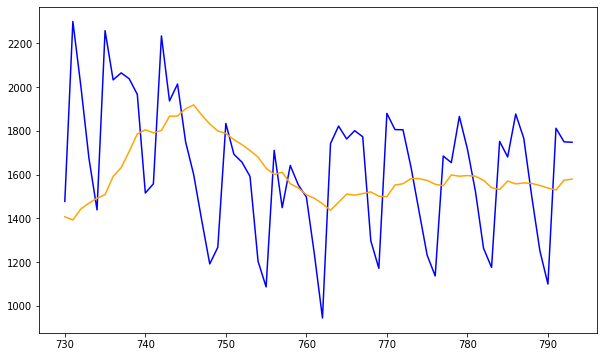

In [19]:
# simple 15 day moving average
moving_avg = moving_average_forecast(series, window_size)[split_time - window_size:]

plt.figure(figsize=(10, 6))
plt.plot(time_valid, x_valid, color='blue')
plt.plot(time_valid, moving_avg, color='orange');

In [20]:
# this is worse than the naive forecast
print(tf.keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

268.30103


pandas dataframe.rolling

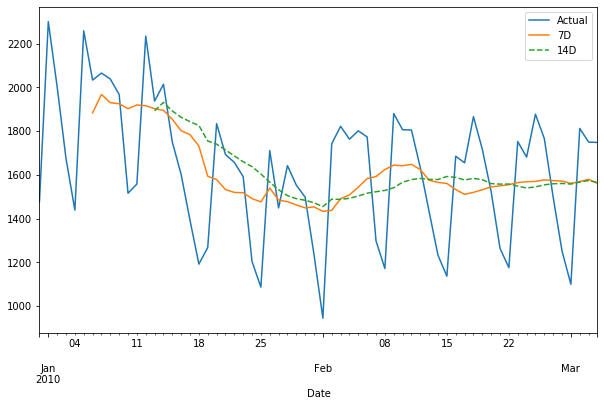

In [21]:
sequence_data['Volume'][split_time:].plot(figsize=(10,6),legend=True, label='Actual')
sequence_data['Volume'][split_time:].rolling(window=7).mean().plot(figsize=(10,6), legend=True, label='7D')
sequence_data['Volume'][split_time:].rolling(window=14).mean().plot(figsize=(10,6),  ls='--', legend=True, label='14D');

### 3) Exponential Weighted Moving Average

ewma has only one smoothing factor alpha and didn't consider trend or seasonality

In [22]:
sequence_data['ewma']=sequence_data['Volume'].ewm(span=7,adjust=False).mean()
sequence_data['simple_avg']= sequence_data['Volume'].rolling(window=7).mean()

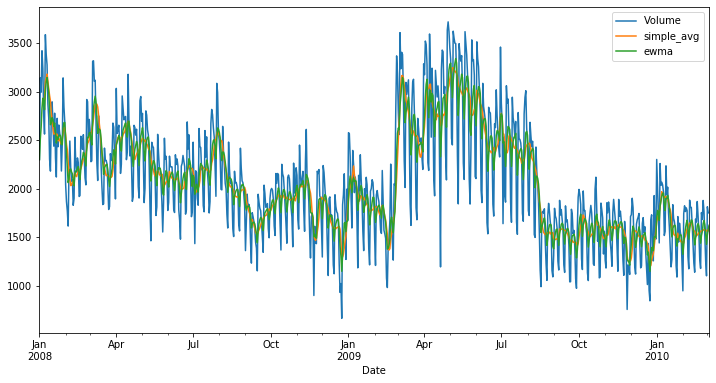

In [23]:
sequence_data[['Volume','simple_avg','ewma']].plot(figsize=(12,6));

In [39]:
# temp_x_valid = sequence_data['Volume'][365:]
# ewma_moving_avg = sequence_data['ewma'][365:]
# print(tf.keras.metrics.mean_absolute_error(temp_x_valid, ewma_moving_avg).numpy())

269.3898630612991


### Holt's Method (Double Exponential Smoothing)

introduce a new smoothing factor (beta) that addresses trend

### Holt-Winters Method (Triple Exponential Smoothing)

introduce a smoothing factor (gamma) that addresses seasonality

In [40]:
# D is calendar day
sequence_data.index.freq='D'

In [24]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [25]:
span = 7
alpha = 2/(span+1)
sequence_data['ewma_7']=sequence_data['Volume'].ewm(alpha=alpha,adjust=False).mean()

In [26]:
sequence_data[['Volume','ewma','ewma_7']].head(10)

Volume         ewma       ewma_7
Date                                        
2008-01-01  2299.0  2299.000000  2299.000000
2008-01-02  3143.0  2510.000000  2510.000000
2008-01-03  2994.0  2631.000000  2631.000000
2008-01-04  3421.0  2828.500000  2828.500000
2008-01-05  3241.0  2931.625000  2931.625000
2008-01-06  2793.0  2896.968750  2896.968750
2008-01-07  2562.0  2813.226562  2813.226562
2008-01-08  3587.0  3006.669922  3006.669922
2008-01-09  3384.0  3101.002441  3101.002441
2008-01-10  3276.0  3144.751831  3144.751831

In [27]:
# this gives the  same value as ewma
span = 7
alpha = 2/(span+1)
model = SimpleExpSmoothing(x_train_df['Volume'])

fitted_model = model.fit(smoothing_level=alpha, optimized=False)

In [28]:
fitted_model.fittedvalues.shift(-1)[:10]

Date
2008-01-01    2299.000000
2008-01-02    2510.000000
2008-01-03    2631.000000
2008-01-04    2828.500000
2008-01-05    2931.625000
2008-01-06    2896.968750
2008-01-07    2813.226562
2008-01-08    3006.669922
2008-01-09    3101.002441
2008-01-10    3144.751831
Freq: D, dtype: float64

In [80]:
x_train_df.tail(10)

Volume
Date              
2009-12-21  1010.0
2009-12-22  1434.0
2009-12-23   951.0
2009-12-24   842.0
2009-12-25  1678.0
2009-12-26  1729.0
2009-12-27  1398.0
2009-12-28  1254.0
2009-12-29  1927.0
2009-12-30  1517.0

In [86]:
fitted_model.forecast()

2009-12-31    1504.533539
Freq: D, dtype: float64

In [ ]:
# in one line
simple_ma=np.array(SimpleExpSmoothing(x_train_df['Volume'].fit(smoothing_level=alpha, optimized=False).fittedvalues.shift(-1)))

### Triple EWMA

In [46]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [49]:
# DO NOT NEED TO SHIFT!!!

sequence_data['triple_ewma'] = ExponentialSmoothing(sequence_data['Volume'], 
                                                    trend='multiplicative',
                                                    seasonal='mul',
                                                    seasonal_periods=365
                                                   ).fit().fittedvalues

In [31]:
sequence_data[['Volume','triple_ewma']].tail(90)

Volume  triple_ewma
Date                           
2009-12-05  1493.0  1532.798476
2009-12-06  1192.0  1348.242480
2009-12-07  1118.0  1118.142369
2009-12-08  1632.0  1185.651455
2009-12-09  1679.0  1700.363330
2009-12-10  1704.0  1716.061669
2009-12-11  1743.0  1626.626456
2009-12-12  1430.0  1542.768377
2009-12-13  1182.0  1359.554190
2009-12-14  1200.0  1171.401099
2009-12-15  1640.0  1346.983546
2009-12-16  1700.0  1816.632846
2009-12-17  1541.0  1672.935636
2009-12-18  1606.0  1662.715607
2009-12-19  1346.0  1538.060114
2009-12-20  1183.0  1404.196234
2009-12-21  1010.0  1110.510790
2009-12-22  1434.0  1186.414282
2009-12-23   951.0  1052.422906
2009-12-24   842.0   970.497286
2009-12-25  1678.0  1720.288712
2009-12-26  1729.0  1807.295524
2009-12-27  1398.0  1769.734655
2009-12-28  1254.0  1465.621391
2009-12-29  1927.0  1610.330712
2009-12-30  1517.0  1745.061063
2009-12-31  1478.0  1617.988582
2010-01-01  2300.0  2314.710084
2010-01-02  2002.0  2194.885806
2010-01-03  1674.0  2160.957076
2010-01-04  1439.0  1861.978387
2010-01-05  2258.0  1716.626211
2010-01-06  2033.0  1894.118485
2010-01-07  2065.0  2222.611567
2010-01-08  2038.0  2048.832966
2010-01-09  1967.0  2028.611958
2010-01-10  1516.0  1764.815660
2010-01-11  1558.0  1597.837160
2010-01-12  2234.0  1490.670064
2010-01-13  1937.0  1738.695646
2010-01-14  2014.0  1961.710492
2010-01-15  1750.0  2042.396576
2010-01-16  1601.0  1814.471474
2010-01-17  1392.0  1607.952607
2010-01-18  1192.0  1554.340347
2010-01-19  1268.0  1309.274666
2010-01-20  1834.0  1494.508569
2010-01-21  1693.0  1702.910164
2010-01-22  1657.0  1653.109909
2010-01-23  1592.0  1692.857444
2010-01-24  1204.0  1495.973709
2010-01-25  1087.0  1316.050209
2010-01-26  1711.0  1238.645546
2010-01-27  1449.0  1545.329156
2010-01-28  1642.0  1802.034943
2010-01-29  1553.0  1671.054795
2010-01-30  1498.0  1575.691129
2010-01-31  1235.0  1256.057288
2010-02-01   945.0  1047.012573
2010-02-02  1742.0  1043.887776
2010-02-03  1822.0  1357.278550
2010-02-04  1763.0  1653.370286
2010-02-05  1801.0  1742.996787
2010-02-06  1773.0  1644.263022
2010-02-07  1298.0  1457.766659
2010-02-08  1172.0  1342.814991
2010-02-09  1880.0  1398.276345
2010-02-10  1806.0  1684.474433
2010-02-11  1805.0  1784.218803
2010-02-12  1633.0  1576.861314
2010-02-13  1431.0  1489.843544
2010-02-14  1232.0  1451.435455
2010-02-15  1137.0  1277.796280
2010-02-16  1685.0  1279.429416
2010-02-17  1655.0  1447.098339
2010-02-18  1866.0  1778.453851
2010-02-19  1717.0  1765.906602
2010-02-20  1523.0  1766.953295
2010-02-21  1264.0  1616.699025
2010-02-22  1176.0  1382.198281
2010-02-23  1752.0  1393.237926
2010-02-24  1681.0  1547.548267
2010-02-25  1877.0  1944.566978
2010-02-26  1766.0  2061.590539
2010-02-27  1498.0  1971.246720
2010-02-28  1252.0  1880.138099
2010-03-01  1100.0  1615.828648
2010-03-02  1812.0  1491.600420
2010-03-03  1750.0  1834.568180
2010-03-04  1748.0  1948.493820

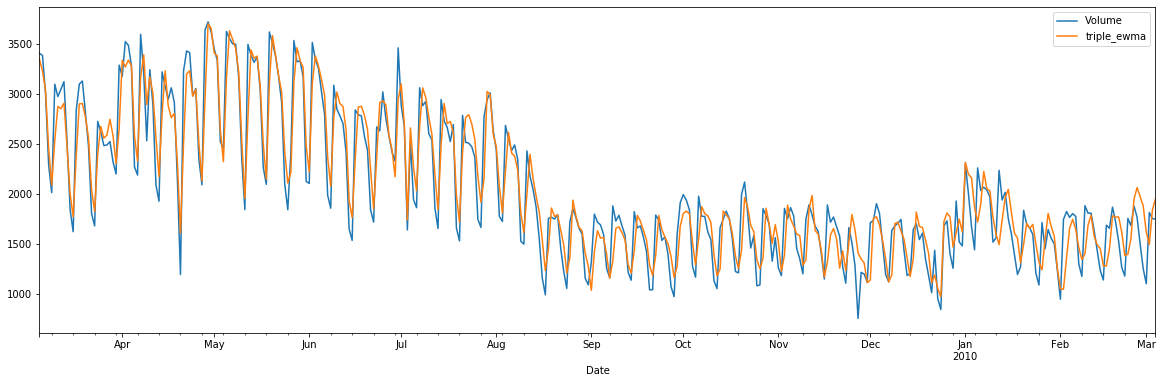

In [32]:
sequence_data[['Volume','triple_ewma']].iloc[-365:].plot(figsize=(20,6));

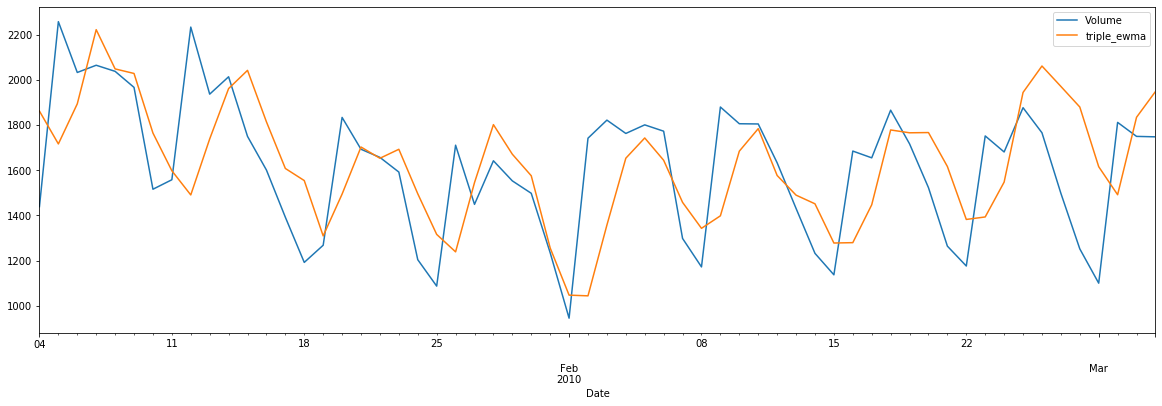

In [33]:
sequence_data[['Volume','triple_ewma']].iloc[-60:].plot(figsize=(20,6));

In [105]:
# sequence_data['double_ewma'][365:]

In [37]:
# temp_x_valid = sequence_data['Volume'][365:]
# # double_ewma_moving_avg = sequence_data['double_ewma'][365:]
# print(tf.keras.metrics.mean_absolute_error(temp_x_valid, triple_ewma).numpy())

### Using Triple EWMA to Forecast

In [90]:
x_train_df.head(5)

Volume
Date              
2008-01-01  2299.0
2008-01-02  3143.0
2008-01-03  2994.0
2008-01-04  3421.0
2008-01-05  3241.0

In [50]:
fitted_model = ExponentialSmoothing(x_train_df['Volume'], 
                                    trend='multiplicative',
                                    seasonal='mul',
                                    seasonal_periods=365
                                    ).fit()

In [51]:
test_predictions = fitted_model.forecast(64)

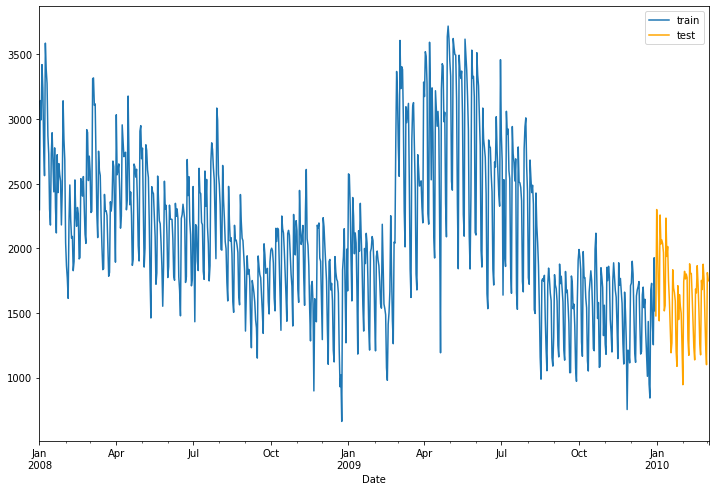

In [52]:
x_train_df['Volume'].plot(legend=True, label='train', figsize=(12,8))
x_valid_df['Volume'].plot(legend=True, label='test',color='orange');

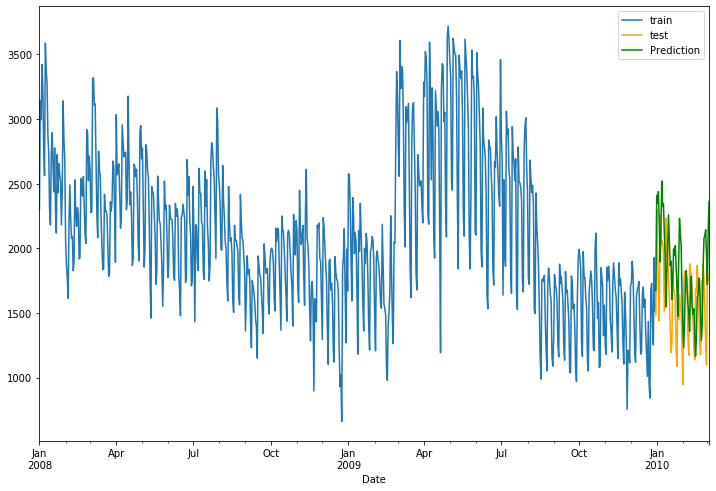

In [53]:
x_train_df['Volume'].plot(legend=True, label='train', figsize=(12,8))
x_valid_df['Volume'].plot(legend=True, label='test',color='orange')
test_predictions.plot(legend=True, label='Prediction', color='green');

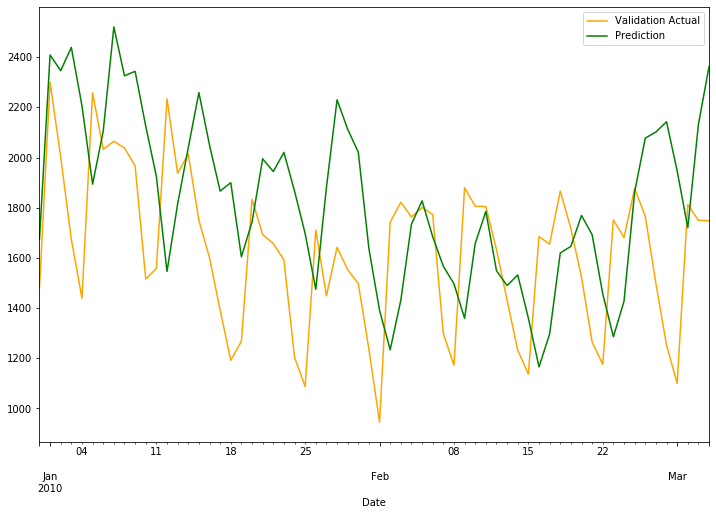

In [54]:
x_valid_df['Volume'].plot(legend=True, label='Validation Actual',color='orange', figsize=(12,8))
test_predictions.plot(legend=True, label='Prediction', color='green');

In [55]:
# seem to overforecast
print(tf.keras.metrics.mean_absolute_error(x_valid, np.array(test_predictions)).numpy())

362.6291559708529


### 4) Remove Seasonality： Differencing

That's worse than naive forecast! The moving average does not anticipate trend or seasonality, so let's try to remove them by using differencing. Since the seasonality period is 365 days, we will subtract the value at time t – 365 from the value at time t.

<Figure size 720x432 with 0 Axes>

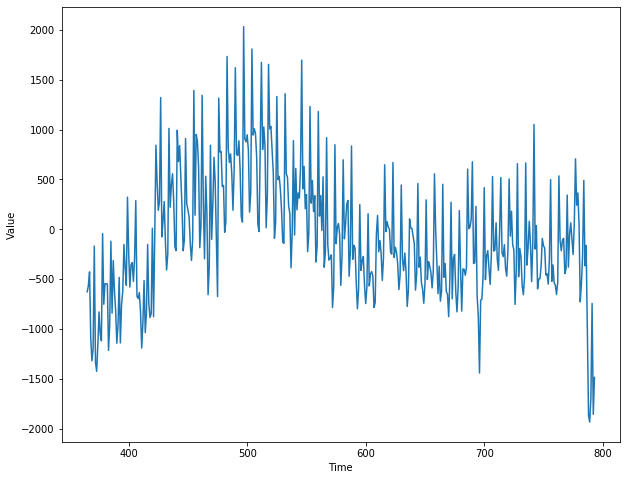

In [34]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show();

<Figure size 720x432 with 0 Axes>

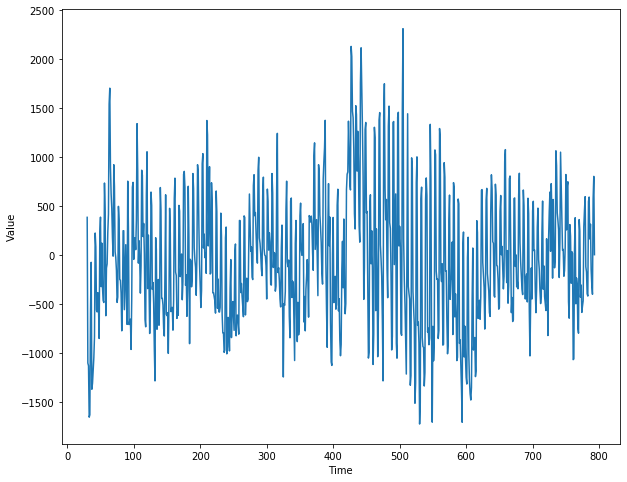

In [35]:
diff_series = (series[30:] - series[:-30])
diff_time = time[30:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show();

<Figure size 720x432 with 0 Axes>

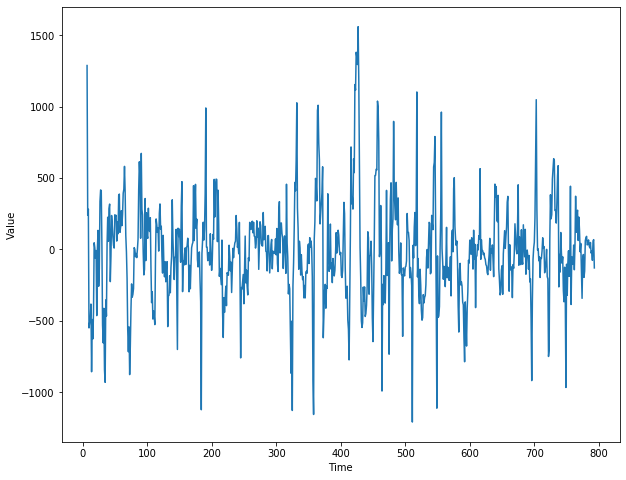

In [36]:
diff_series = (series[7:] - series[:-7])
diff_time = time[7:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show();

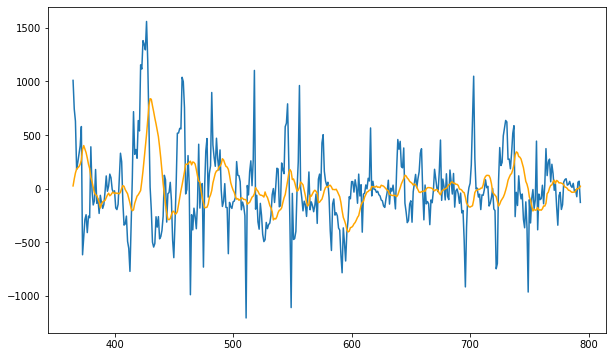

In [38]:
diff_moving_avg = moving_average_forecast(diff_series, window_size)[split_time - 7 - window_size:]

plt.figure(figsize=(10, 6))
plt.plot(time_valid, diff_series[split_time - 7:])
plt.plot(time_valid, diff_moving_avg, color='orange')
plt.show();

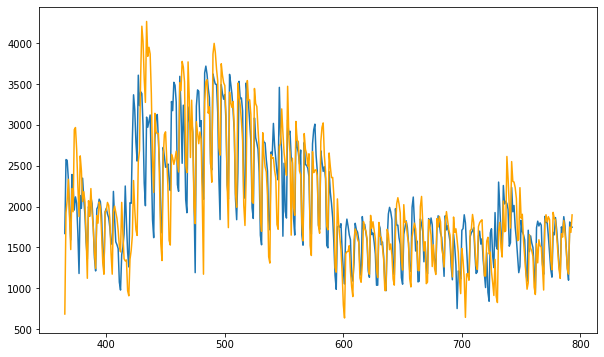

In [39]:
diff_moving_avg_plus_past = series[split_time - 7:-7] + diff_moving_avg

plt.figure(figsize=(10, 6))
plt.plot(time_valid, x_valid)
plt.plot(time_valid, diff_moving_avg_plus_past, color='orange')
plt.show();

In [40]:
# this is actually worse than before when using 15 days to remove seasonality
print(tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

287.42501942501934


#### Using Pandas & statmodels

- take first degree differencing
- if the difference shows stationarity, stop there, take moving average
- use last Monday's data plus moving average on the difference to predict 

In [ ]:
sequence_data['first_order_differencing'] = sequence_data['Volume'] - sequence_data['Volume'].shift(1)

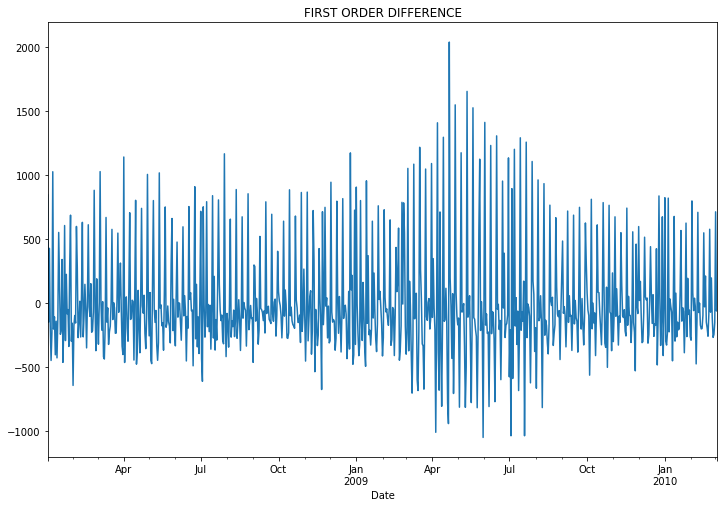

In [90]:
sequence_data['first_order_differencing'].plot(title="FIRST ORDER DIFFERENCE").autoscale(axis='x',tight=True);

In [79]:
#first order differencing

sequence_data['ma_first_order_differencing'] = sequence_data['first_order_differencing'].rolling(7).mean()

sequence_data[['Volume','first_order_differencing','ma_first_order_differencing']].head(10)

Volume  first_order_differencing  ma_first_order_differencing
Date                                                                     
2008-01-01  2299.0                       NaN                          NaN
2008-01-02  3143.0                     844.0                          NaN
2008-01-03  2994.0                    -149.0                          NaN
2008-01-04  3421.0                     427.0                          NaN
2008-01-05  3241.0                    -180.0                          NaN
2008-01-06  2793.0                    -448.0                          NaN
2008-01-07  2562.0                    -231.0                          NaN
2008-01-08  3587.0                    1025.0                   184.000000
2008-01-09  3384.0                    -203.0                    34.428571
2008-01-10  3276.0                    -108.0                    40.285714

In [84]:
sequence_data['first_order_differrencing_forecast']=sequence_data['Volume'].shift(7)+sequence_data['ma_first_order_differencing']

In [89]:
sequence_data[['Volume', 'first_order_differencing',
               'ma_first_order_differencing','first_order_differrencing_forecast']].tail(10)

Volume  first_order_differencing  ma_first_order_differencing  \
Date                                                                        
2010-02-23  1752.0                     576.0                     9.571429   
2010-02-24  1681.0                     -71.0                     3.714286   
2010-02-25  1877.0                     196.0                     1.571429   
2010-02-26  1766.0                    -111.0                     7.000000   
2010-02-27  1498.0                    -268.0                    -3.571429   
2010-02-28  1252.0                    -246.0                    -1.714286   
2010-03-01  1100.0                    -152.0                   -10.857143   
2010-03-02  1812.0                     712.0                     8.571429   
2010-03-03  1750.0                     -62.0                     9.857143   
2010-03-04  1748.0                      -2.0                   -18.428571   

            first_order_differrencing_forecast  
Date                                            
2010-02-23                         1694.571429  
2010-02-24                         1658.714286  
2010-02-25                         1867.571429  
2010-02-26                         1724.000000  
2010-02-27                         1519.428571  
2010-02-28                         1262.285714  
2010-03-01                         1165.142857  
2010-03-02                         1760.571429  
2010-03-03                         1690.857143  
2010-03-04                         1858.571429

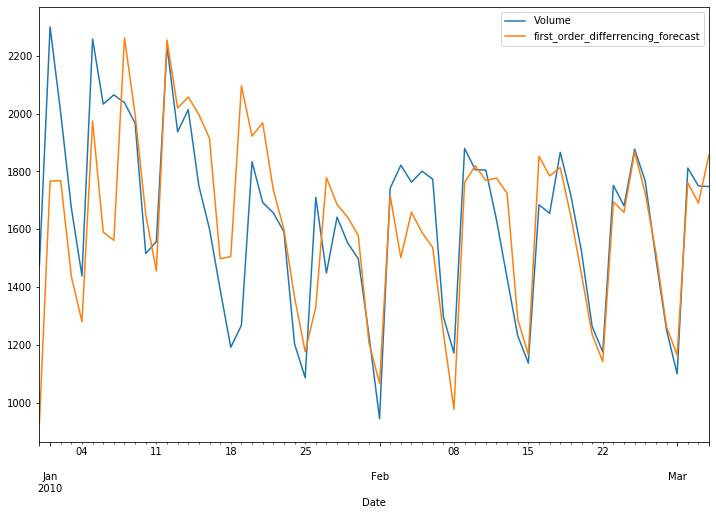

In [92]:
sequence_data.loc['2009-12-31':][['Volume','first_order_differrencing_forecast']].plot();

            Volume  weekly_differencing
Date                                   
2008-01-01  2299.0                  NaN
2008-01-02  3143.0                  NaN
2008-01-03  2994.0                  NaN
2008-01-04  3421.0                  NaN
2008-01-05  3241.0                  NaN
2008-01-06  2793.0                  NaN
2008-01-07  2562.0                  NaN
2008-01-08  3587.0               1288.0
2008-01-09  3384.0                241.0
2008-01-10  3276.0                282.0


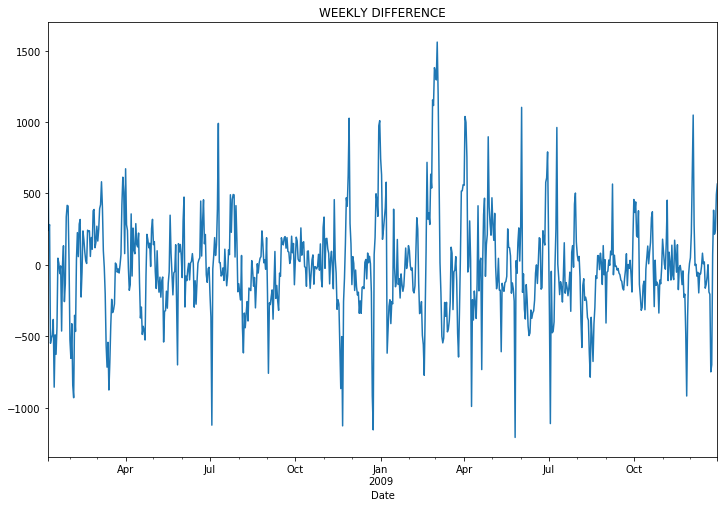

In [68]:
# An easier way to perform differencing on a pandas Series or DataFrame is to use the built-in .diff() method:

x_train_df['weekly_differencing'] = x_train_df['Volume'].diff(periods=7)
print(x_train_df[['Volume','weekly_differencing']].head(10))
x_train_df['weekly_differencing'].plot(title="WEEKLY DIFFERENCE").autoscale(axis='x',tight=True);

In [ ]:
# second degree differencing
x_train_df['Volume'].diff().diff()

In [66]:
from statsmodels.tsa.statespace.tools import diff

diff(x_train_df['Volume'], k_diff=1)

Date
2008-01-02     844.0
2008-01-03    -149.0
2008-01-04     427.0
2008-01-05    -180.0
2008-01-06    -448.0
2008-01-07    -231.0
2008-01-08    1025.0
2008-01-09    -203.0
2008-01-10    -108.0
2008-01-11    -404.0
2008-01-12    -142.0
2008-01-13    -428.0
2008-01-14    -122.0
2008-01-15     551.0
2008-01-16     163.0
2008-01-17    -244.0
2008-01-18    -213.0
2008-01-19     340.0
2008-01-20    -463.0
2008-01-21    -195.0
2008-01-22     605.0
2008-01-23    -293.0
2008-01-24     224.0
2008-01-25     -84.0
2008-01-26     -51.0
2008-01-27    -339.0
2008-01-28     274.0
2008-01-29     686.0
2008-01-30    -298.0
2008-01-31    -157.0
2008-02-01    -643.0
2008-02-02    -177.0
2008-02-03     -97.0
2008-02-04    -156.0
2008-02-05     598.0
2008-02-06     279.0
2008-02-07    -270.0
2008-02-08    -142.0
2008-02-09      14.0
2008-02-10    -265.0
2008-02-11      72.0
2008-02-12     630.0
2008-02-13    -264.0
2008-02-14     -95.0
2008-02-15     146.0
2008-02-16     -48.0
2008-02-17    -350.0
2008-02-

# ARIMA

### ACF & PACF

In [8]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols

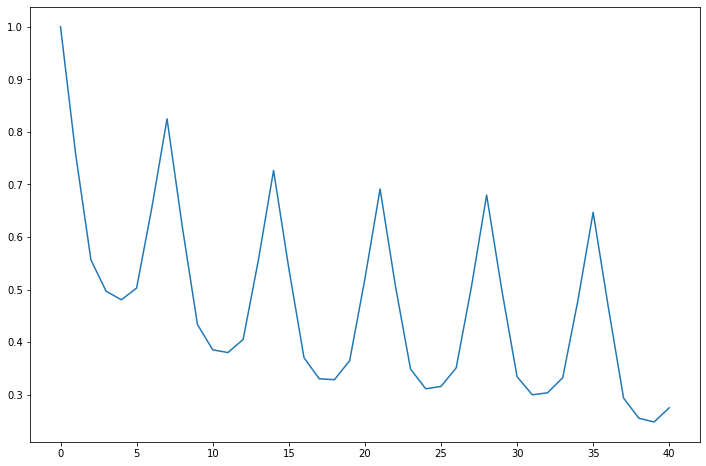

In [9]:
plt.plot(acf(sequence_data['Volume']));

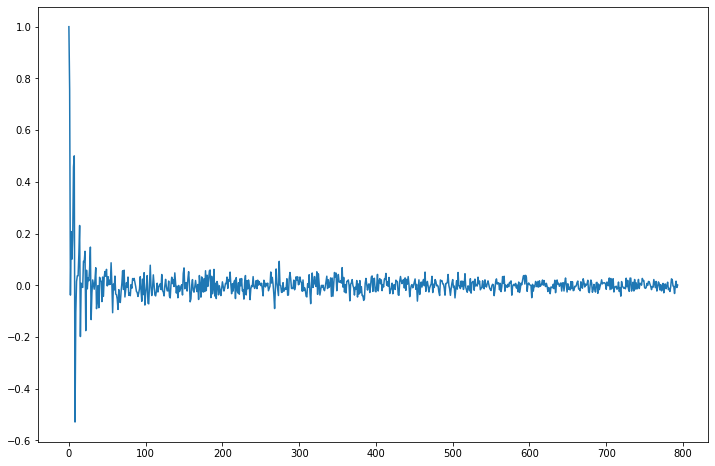

In [19]:
plt.plot(pacf_yw(sequence_data['Volume'], nlags=793, method='mle')); #maximum loglikelihood estimate

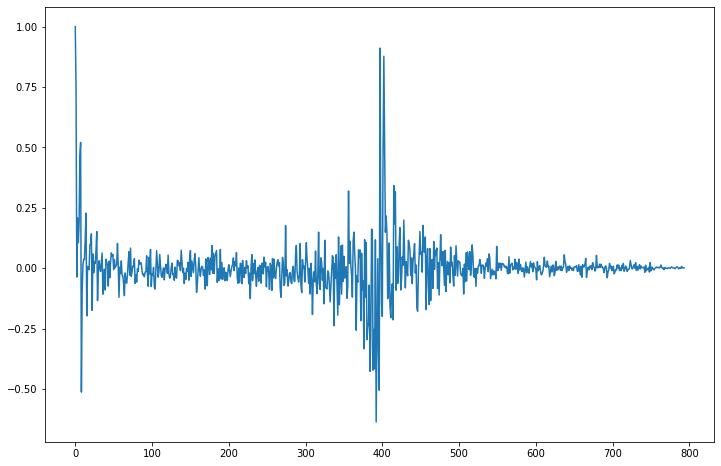

In [20]:
plt.plot(pacf_ols(sequence_data['Volume'], nlags=793));

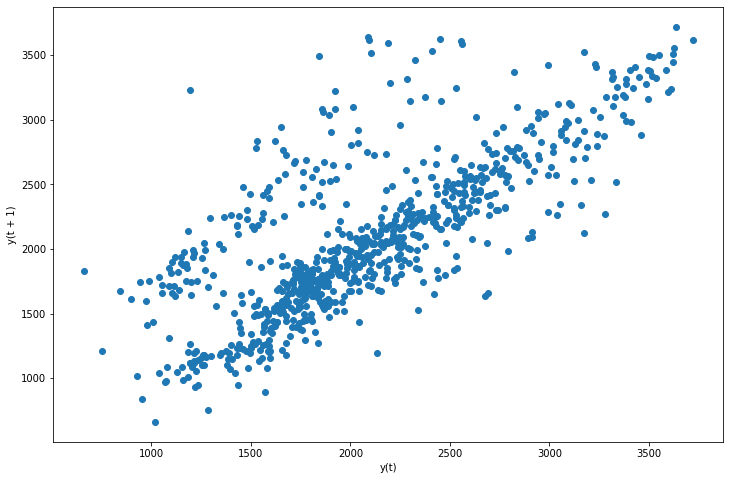

In [23]:
from pandas.plotting import lag_plot

# shows strong auto correlation
lag_plot(sequence_data['Volume']);

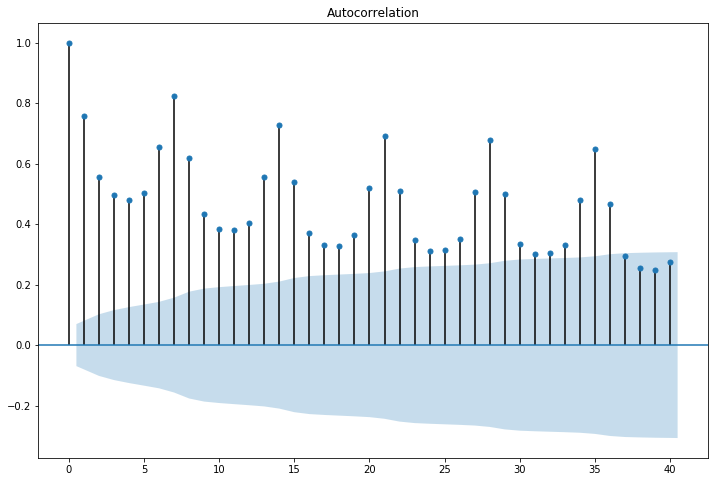

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# the shaded area indicates confidence interval
plot_acf(sequence_data, lags=40);

In [34]:
random_stationary_data=np.random.randint(low=0, high=100, size=100)

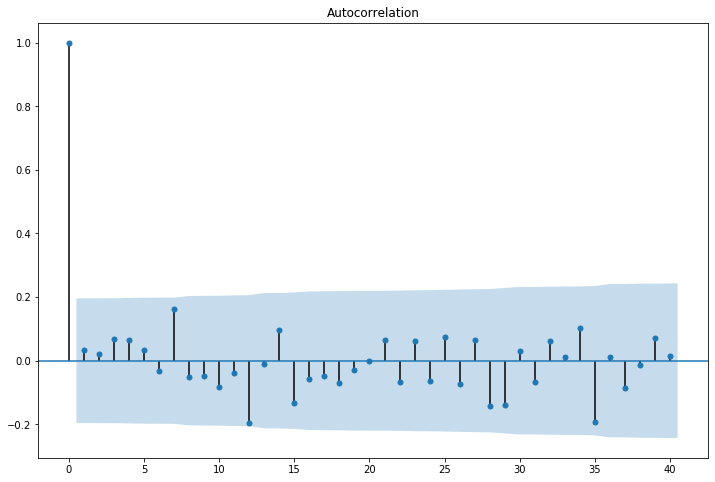

In [36]:
# this is a stationary series and expected to see big drop off
plot_acf(random_stationary_data, lags=40);

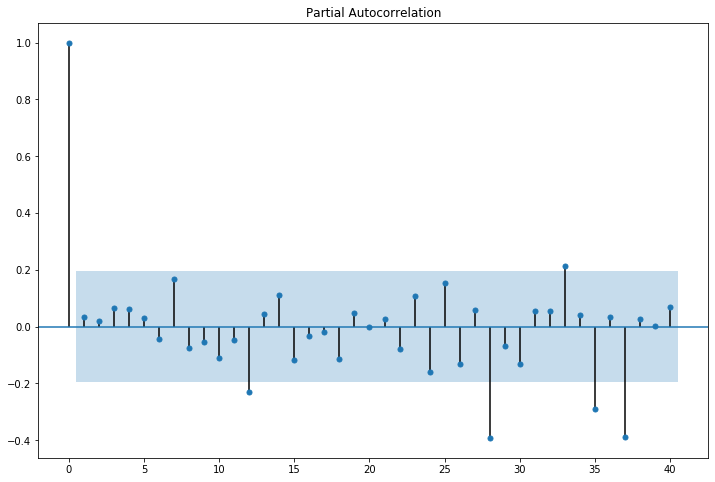

In [37]:
plot_pacf(random_stationary_data, lags=40);

### Auto Regression Model

In [11]:
from statsmodels.tsa.ar_model import AR, ARResults

In [38]:
model = AR(x_train_df['Volume'])

# AR1fit=model.fit(maxlag=1, method='cmle')
AR1fit=model.fit(maxlag=7)

print(f'Lag: {AR1fit.k_ar}')
print(f'Coefficients:\n{AR1fit.params}')

Lag: 7
Coefficients:
const        79.068925
L1.Volume     0.421855
L2.Volume    -0.109316
L3.Volume     0.059346
L4.Volume     0.014750
L5.Volume    -0.068451
L6.Volume     0.118155
L7.Volume     0.522040
dtype: float64


In [39]:
start=len(x_train_df)
end=len(x_train_df)+len(x_valid_df)-1
print("start:", start, "end:", end)
predictions7 = AR1fit.predict(start=start, end=end, dynamic=False).rename('AR(7) Predictions')

start: 730 end: 793


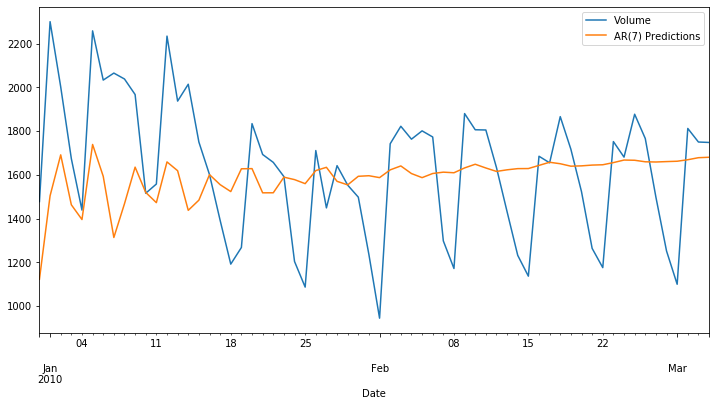

In [40]:
x_valid_df['Volume'].plot(legend=True)
predictions7.plot(legend=True,figsize=(12,6));

#### Fit an AR(p) model where statsmodels chooses p

In [32]:
ARfit = model.fit(ic='t-stat')
print(f'Lag: {ARfit.k_ar}')
print(f'Coefficients:\n{ARfit.params}')

Lag: 20
Coefficients:
const         77.168000
L1.Volume      0.660365
L2.Volume      0.033211
L3.Volume      0.035995
L4.Volume      0.035014
L5.Volume      0.013737
L6.Volume     -0.006114
L7.Volume      0.493105
L8.Volume     -0.320472
L9.Volume     -0.082852
L10.Volume     0.001092
L11.Volume     0.018434
L12.Volume    -0.046788
L13.Volume    -0.053928
L14.Volume     0.344407
L15.Volume    -0.219166
L16.Volume    -0.000228
L17.Volume    -0.013371
L18.Volume    -0.049781
L19.Volume     0.010889
L20.Volume     0.107457
dtype: float64


In [35]:
start=len(x_train_df)
end=len(x_train_df)+len(x_valid_df)-1
print("start:", start, "end:", end)
predictions20 = ARfit.predict(start=start, end=end, dynamic=False).rename('AR(20) Predictions')

start: 730 end: 793


In [70]:
type(predictions20)

pandas.core.series.Series

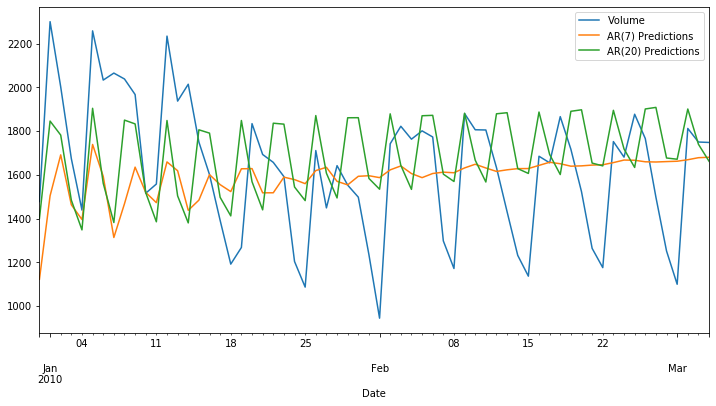

In [41]:
x_valid_df['Volume'].plot(legend=True)
predictions7.plot(legend=True,figsize=(12,6))
predictions20.plot(legend=True,figsize=(12,6));

In [34]:
# ARfit = model.fit(method='mle', ic='t-stat')
# print(f'Lag: {ARfit.k_ar}')
# print(f'Coefficients:\n{ARfit.params}')

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [44]:
labels=['AR7','AR20']

preds =[predictions7, predictions20]

for i in range(2):
    error = mean_absolute_error(x_valid_df['Volume'], preds[i])
    print(f'{labels[i]} MSE was: {error}')

AR7 MSE was: 253.68506917709905
AR20 MSE was: 262.5790001826793


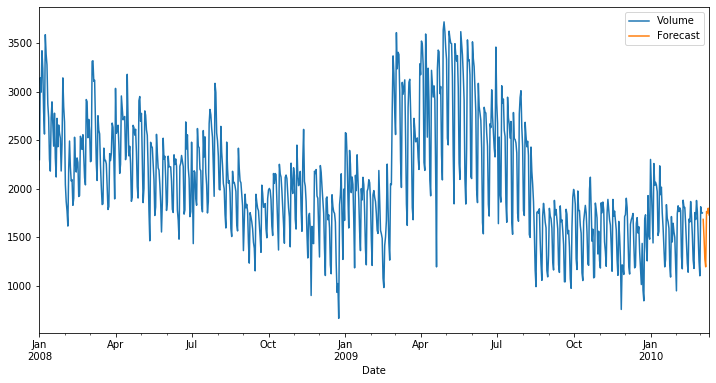

In [84]:
# fit with all available data
model = AR(sequence_data['Volume'])

# Next, fit the model
ARfit = model.fit(maxlag=20)

# Make predictions
fcast = ARfit.predict(start=len(sequence_data), end=len(sequence_data)+7, dynamic=False).rename('Forecast')

# Plot the results
sequence_data['Volume'].plot(legend=True)
fcast.plot(legend=True,figsize=(12,6));

In [85]:
print(fcast)

2010-03-05    1682.084830
2010-03-06    1492.875171
2010-03-07    1270.022929
2010-03-08    1192.564147
2010-03-09    1763.494770
2010-03-10    1748.042934
2010-03-11    1797.261425
2010-03-12    1728.101696
Freq: D, Name: Forecast, dtype: float64


###  Augmented Dickey-Fuller Test

To determine whether a series is stationary we can use the augmented Dickey-Fuller Test. In this test the null hypothesis states that  𝜙=1  (this is also called a unit test). The test returns several statistics we'll see in a moment. Our focus is on the p-value. A small p-value ( 𝑝<0.05 ) indicates strong evidence against the null hypothesis.

In [86]:
from statsmodels.tsa.stattools import adfuller,kpss,coint,bds,q_stat,grangercausalitytests,levinson_durbin

In [87]:
dftest=adfuller(sequence_data['Volume'])

In [97]:
dfout=pd.Series(dftest[0:4], index=['ADF Test Statistic', 'p-value', '# Lags Used', '# Observations'])

for key, val in dftest[4].items():
    dfout[f'critical value({key})']=val
    
dfout

ADF Test Statistic      -2.232088
p-value                  0.194806
# Lags Used             21.000000
# Observations         772.000000
critical value(1%)      -3.438849
critical value(5%)      -2.865291
critical value(10%)     -2.568767
dtype: float64

In [15]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [94]:
adf_test(sequence_data['Volume'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.232088
p-value                   0.194806
# lags used              21.000000
# observations          772.000000
critical value (1%)      -3.438849
critical value (5%)      -2.865291
critical value (10%)     -2.568767
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


### Granger's Causality Test

The Granger causality test is a a hypothesis test to determine if one time series is useful in forecasting another. 

In [99]:
df3 = pd.read_csv('Data/samples.csv',index_col=0,parse_dates=True)
df3.index.freq = 'MS'

In [100]:
# the larger maxlag the higher chances to find causality
# look for extremely low p-values
grangercausalitytests(df3[['a','d']],maxlag=3);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7051  , p=0.1942  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=1.7492  , p=0.1860  , df=1
likelihood ratio test: chi2=1.7365  , p=0.1876  , df=1
parameter F test:         F=1.7051  , p=0.1942  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=286.0339, p=0.0000  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=597.3806, p=0.0000  , df=2
likelihood ratio test: chi2=212.6514, p=0.0000  , df=2
parameter F test:         F=286.0339, p=0.0000  , df_denom=113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=188.7446, p=0.0000  , df_denom=110, df_num=3
ssr based chi2 test:   chi2=602.2669, p=0.0000  , df=3
likelihood ratio test: chi2=212.4789, p=0.0000  , df=3
parameter F test:         F=188.7446, p=0.0000  , df_denom=110, df_num=3


### Visualize Seasonality

In [105]:
from statsmodels.graphics.tsaplots import month_plot, quarter_plot

In [128]:
# sequence_data['month']=sequence_data.index.month

In [137]:
sequence_data_monthly = sequence_data.resample('M').mean()

In [141]:
# sequence_data_monthly

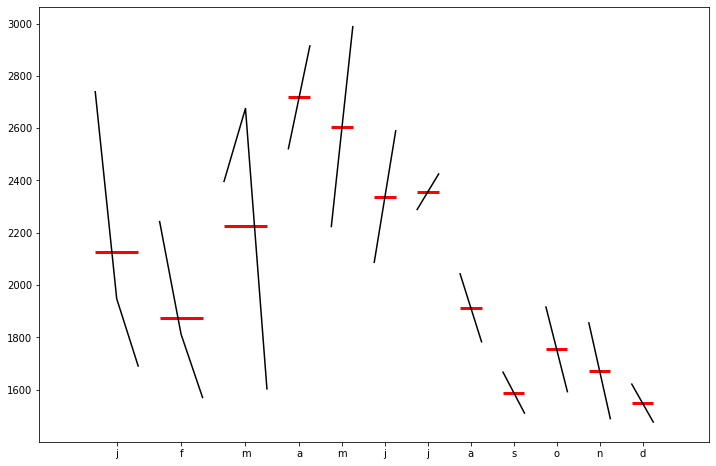

In [140]:
# sequence_data.index.freq='D'
month_plot(sequence_data_monthly['Volume']);

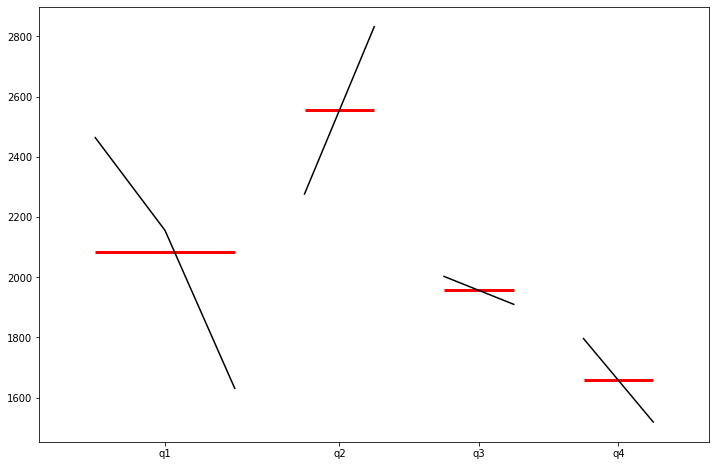

In [146]:
sequence_data_quarterly = sequence_data.resample('Q')['Volume'].mean()
sequence_data_quarterly

quarter_plot(sequence_data_quarterly);

## ARIMA

p is the order (number of time lags) of the autoregressive model, <br>
d is the degree of differencing (the number of times the data have had past values subtracted) <br>
q is the order of the moving-average model <br>

Typically a sharp drop after lag "k" suggests an AR-k model should be used. If there is a gradual decline, it suggests an MA model. 

Identification of n AR model is often best done with the PACF. <br>
Identification of an MA model is often best done with the ACF rather than the PACF. <br>
The pmdarima (Pyramid ARIMA) is a separate library designed to perform grid searches across multiple combinations of p,d,q and P,D,Q. It utilizes the Akaike information criterion as a metric to compare the performance of various ARIMA based models. It panalizes high order model to avoid overfitting. 

In [36]:
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from pmdarima import auto_arima

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
from pmdarima import auto_arima

In [88]:
stepwise_fit = auto_arima(sequence_data['Volume'], start_p=0, start_q=0,
                          max_p=20, max_q=20, m=12, #m=4 for quarterly data, m=12 for monthly data, 1 for annual data
                          seasonal=True,
                          d=1, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

Performing stepwise search to minimize aic
Fit ARIMA: (0, 1, 0)x(1, 0, 1, 12) (constant=True); AIC=11741.488, BIC=11760.191, Time=1.437 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 12) (constant=True); AIC=11836.029, BIC=11845.381, Time=0.031 seconds
Fit ARIMA: (1, 1, 0)x(1, 0, 0, 12) (constant=True); AIC=11771.047, BIC=11789.751, Time=2.328 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 1, 12) (constant=True); AIC=11672.489, BIC=11691.192, Time=1.591 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 12) (constant=False); AIC=11834.032, BIC=11838.708, Time=0.018 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 12) (constant=True); AIC=11791.744, BIC=11805.772, Time=0.240 seconds
Fit ARIMA: (0, 1, 1)x(1, 0, 1, 12) (constant=True); AIC=11666.702, BIC=11690.081, Time=2.735 seconds
Fit ARIMA: (0, 1, 1)x(1, 0, 0, 12) (constant=True); AIC=11759.401, BIC=11778.104, Time=1.308 seconds
Fit ARIMA: (0, 1, 1)x(2, 0, 1, 12) (constant=True); AIC=11598.097, BIC=11626.152, Time=8.487 seconds
Fit ARIMA: (0, 1, 1)x(2, 0, 0, 12) (constant=Tr

In [89]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  794
Model:             SARIMAX(3, 1, 2)x(1, 0, [1], 12)   Log Likelihood               -5662.479
Date:                              Sat, 11 Apr 2020   AIC                          11342.959
Time:                                      09:33:24   BIC                          11385.041
Sample:                                           0   HQIC                         11359.131
                                              - 794                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -6.4375     10.118     -0.636      0.525     -26.268      13.393
ar.L1          0.7793      0.031     25.016      0.000       0.718       0.840
ar.L2         -0.4175      0.039    -10.840      0.000      -0.493      -0.342
ar.L3         -0.4547      0.031    -14.892      0.000      -0.514      -0.395
ma.L1         -1.2794      0.015    -87.056      0.000      -1.308      -1.251
ma.L2          0.9284      0.016     59.817      0.000       0.898       0.959
ar.S.L12      -0.5875      0.072     -8.155      0.000      -0.729      -0.446
ma.S.L12       0.1844      0.085      2.177      0.029       0.018       0.350
sigma2      9.537e+04   4171.136     22.865      0.000    8.72e+04    1.04e+05
===================================================================================
Ljung-Box (Q):                     1400.07   Jarque-Bera (JB):                35.52
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             0.09
Prob(H) (two-sided):                  0.40   Kurtosis:                         4.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
auto_arima(sequence_data['Volume'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  794
Model:               SARIMAX(5, 1, 4)   Log Likelihood               -5543.351
Date:                Fri, 10 Apr 2020   AIC                          11108.702
Time:                        15:09:35   BIC                          11160.136
Sample:                             0   HQIC                         11128.468
                                - 794                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -3.9949     27.335     -0.146      0.884     -57.571      49.581
ar.L1          0.2505      0.055      4.571      0.000       0.143       0.358
ar.L2         -1.0045      0.043    -23.467      0.000      -1.088      -0.921
ar.L3          0.0170      0.076      0.223      0.823      -0.132       0.166
ar.L4         -0.5539      0.044    -12.693      0.000      -0.639      -0.468
ar.L5         -0.5346      0.051    -10.552      0.000      -0.634      -0.435
ma.L1         -0.7158      0.047    -15.092      0.000      -0.809      -0.623
ma.L2          1.2370      0.045     27.549      0.000       1.149       1.325
ma.L3         -0.7190      0.046    -15.605      0.000      -0.809      -0.629
ma.L4          0.7880      0.045     17.504      0.000       0.700       0.876
sigma2      1.074e+05   6684.986     16.071      0.000    9.43e+04    1.21e+05
===================================================================================
Ljung-Box (Q):                      481.86   Jarque-Bera (JB):               112.78
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                             0.12
Prob(H) (two-sided):                  0.36   Kurtosis:                         4.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
from statsmodels.tsa.statespace.tools import diff
sequence_data['d1'] = diff(sequence_data['Volume'],k_diff=1)

In [22]:
# differencing make it stationary
adf_test(sequence_data['d1'],'Real sign-up volume')

Augmented Dickey-Fuller Test: Real sign-up volume
ADF test statistic     -8.239814e+00
p-value                 5.757600e-13
# lags used             2.100000e+01
# observations          7.710000e+02
critical value (1%)    -3.438860e+00
critical value (5%)    -2.865296e+00
critical value (10%)   -2.568770e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


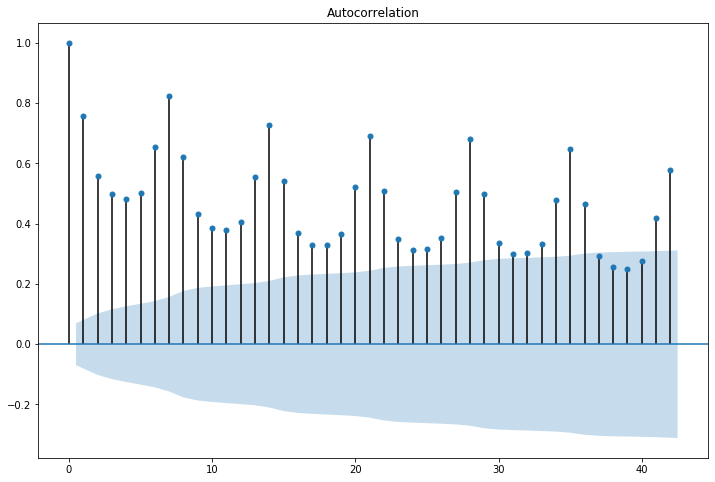

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(sequence_data['Volume'],lags=42);

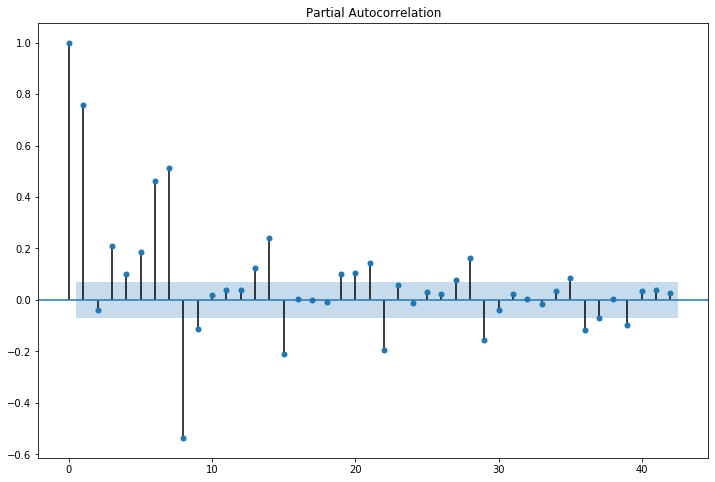

In [33]:
plot_pacf(sequence_data['Volume'], lags=42);

In [83]:
model = ARIMA(x_train_df['Volume'],order=(4,1,7))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Volume   No. Observations:                  729
Model:                 ARIMA(4, 1, 7)   Log Likelihood               -5124.538
Method:                       css-mle   S.D. of innovations            271.513
Date:                Fri, 10 Apr 2020   AIC                          10275.076
Time:                        18:47:22   BIC                          10334.768
Sample:                    01-02-2008   HQIC                         10298.107
                         - 12-30-2009                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.7917      4.325     -0.183      0.855      -9.269       7.685
ar.L1.D.Volume    -0.5578      0.003   -171.337      0.000      -0.564      -0.551
ar.L2.D.Volume     0.2430      0.005     53.715      0.000       0.234       0.252
ar.L3.D.Volume    -0.5531      0.004   -157.638      0.000      -0.560      -0.546
ar.L4.D.Volume    -0.9959      0.003   -379.694      0.000      -1.001      -0.991
ma.L1.D.Volume     0.1650      0.035      4.757      0.000       0.097       0.233
ma.L2.D.Volume    -0.8752      0.036    -24.008      0.000      -0.947      -0.804
ma.L3.D.Volume     0.6119      0.046     13.335      0.000       0.522       0.702
ma.L4.D.Volume     0.9684      0.034     28.847      0.000       0.903       1.034
ma.L5.D.Volume    -0.6620      0.041    -16.198      0.000      -0.742      -0.582
ma.L6.D.Volume    -0.2468      0.043     -5.752      0.000      -0.331      -0.163
ma.L7.D.Volume     0.2666      0.038      7.001      0.000       0.192       0.341
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6236           -0.7838j            1.0016           -0.1430
AR.2            0.6236           +0.7838j            1.0016            0.1430
AR.3           -0.9013           -0.4342j            1.0004           -0.4285
AR.4           -0.9013           +0.4342j            1.0004            0.4285
MA.1           -0.9008           -0.4442j            1.0044           -0.4271
MA.2           -0.9008           +0.4442j            1.0044            0.4271
MA.3           -1.3974           -0.0000j            1.3974           -0.5000
MA.4            0.6366           -0.8163j            1.0352           -0.1446
MA.5            0.6366           +0.8163j            1.0352            0.1446
MA.6            1.4259           -0.6709j            1.5759           -0.0700
MA.7            1.4259           +0.6709j            1.5759            0.0700
-----------------------------------------------------------------------------
"""

In [84]:
start=len(x_train_df)
end=len(x_train_df)+len(x_valid_df)-1
# linear: return prediction in terms of the difference endogenous variables
# levels: return prediction of the original endogenous variables
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(3,1,2) Predictions')

In [90]:
# for i in range(len(predictions))
for i in range(10):
    print(f"predicted={predictions[i]:<11.10}, expected={x_valid_df['Volume'][i]}")

predicted=1664.06574 , expected=1478.0
predicted=1653.71726 , expected=2300.0
predicted=1455.354423, expected=2002.0
predicted=1500.434606, expected=1674.0
predicted=1361.590386, expected=1439.0
predicted=1708.637146, expected=2258.0
predicted=1597.481124, expected=2033.0
predicted=1773.457081, expected=2065.0
predicted=1592.330466, expected=2038.0
predicted=1449.723657, expected=1967.0


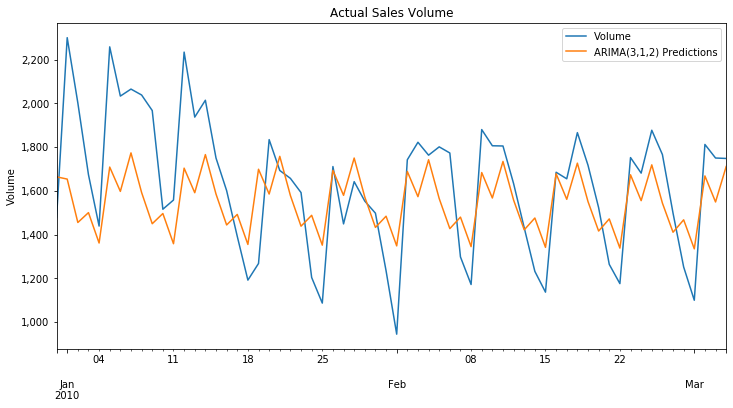

In [86]:
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

title = 'Actual Sales Volume'
ylabel='Volume'
xlabel='' # we don't really need a label here

ax = x_valid_df['Volume'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

In [87]:
from statsmodels.tools.eval_measures import rmse

error = rmse(x_valid_df['Volume'], predictions)
print("RMSE of first ARIMA model (4,1,7):", error)

RMSE of first ARIMA model (4,1,7): 250.85043233318964


### FORECAST INTO THE UNKNOWN FUTURE

In [91]:
# retrain model using entire dataset

model = ARIMA(sequence_data['Volume'], order=(4,1,7))
results=model.fit()
fcast = results.predict(start=len(sequence_data), end=len(sequence_data)+28, typ='levels').rename('ARIMA (4,1,7) FORECAST')

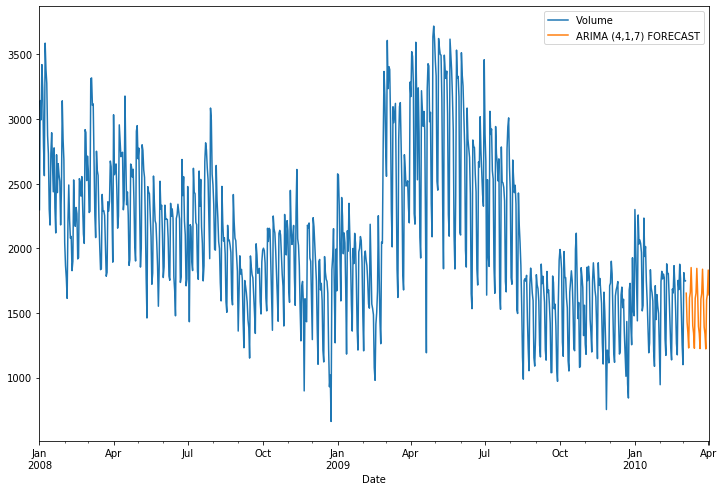

In [93]:
sequence_data['Volume'].plot(legend=True, figsize=(12,8))
fcast.plot(legend=True);

### SARIMA

- Where ARIMA accepts the parameters (p, d, q), SARIMA accepts an additional set of parameters (P, D, Q) that specifically describe the seasonal components of the model. 

In [94]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [96]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [97]:
from pmdarima import auto_arima

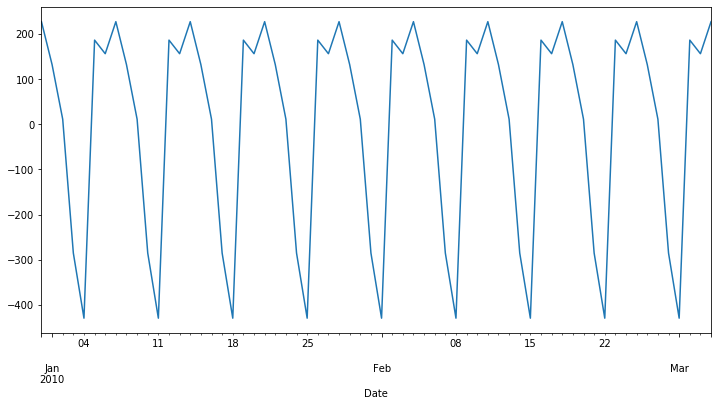

In [102]:
result = seasonal_decompose(x_valid_df['Volume'], model='addictive')  # model='mul' also works
result.seasonal.plot(figsize=(12,6));

In [103]:
auto_arima(sequence_data['Volume'],seasonal=True, m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  794
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 7)   Log Likelihood               -5391.234
Date:                             Sat, 11 Apr 2020   AIC                          10798.467
Time:                                     10:30:14   BIC                          10835.874
Sample:                                          0   HQIC                         10812.843
                                             - 794                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0014      0.002     -0.826      0.409      -0.005       0.002
ar.L1         -0.2046      0.015    -13.575      0.000      -0.234      -0.175
ar.L2          0.7953      0.016     49.374      0.000       0.764       0.827
ma.L1          0.0004      0.031      0.012      0.991      -0.061       0.062
ma.L2         -0.9996      0.031    -32.424      0.000      -1.060      -0.939
ar.S.L7        0.9975      0.002    570.881      0.000       0.994       1.001
ma.S.L7       -0.7768      0.018    -43.943      0.000      -0.811      -0.742
sigma2      4.623e+04   1.34e-06   3.46e+10      0.000    4.62e+04    4.62e+04
===================================================================================
Ljung-Box (Q):                       65.80   Jarque-Bera (JB):               515.95
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             0.25
Prob(H) (two-sided):                  0.38   Kurtosis:                         6.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.2e+25. Standard errors may be unstable.
"""

In [143]:
# possible candidates are 7, 28, 90, 365
model = SARIMAX(x_train_df['Volume'], order=(5,1,7), seasonal_order=(1,0,1,90))

In [144]:
results= model.fit()

In [ ]:
results.summary()

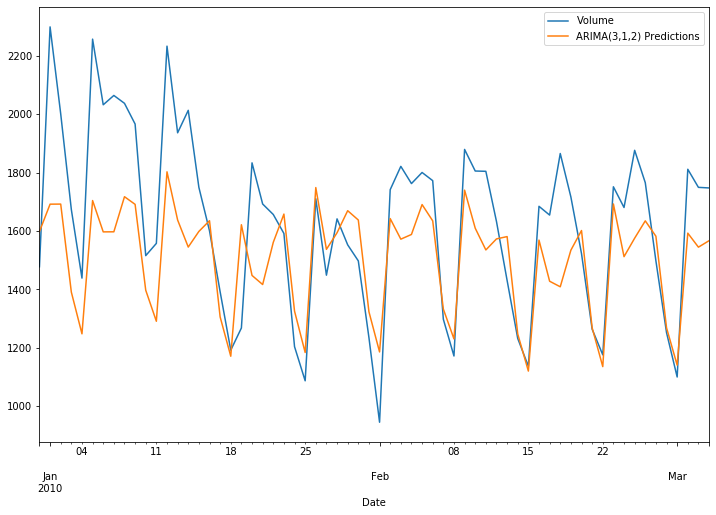

In [139]:
start=len(x_train_df)
end=len(x_train_df)+len(x_valid_df)-1
# linear: return prediction in terms of the difference endogenous variables
# levels: return prediction of the original endogenous variables
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(3,1,2) Predictions')
x_valid_df['Volume'].plot(legend=True, figsize=(12,8))
predictions.plot(legend=True);

In [140]:
from statsmodels.tools.eval_measures import rmse

error = rmse(x_valid_df['Volume'], predictions)
print("RMSE of first SARIMA Model:", error)

RMSE of first SARIMA Model: 233.18893708837217


### SARIMAX

In [164]:
sequence_data_v2=pd.read_csv(r'C:\Users\jli\Documents\JLI\Code & Examples\python_for_time_series\UDEMY_TSA_FINAL\sequence_data_v2.csv', parse_dates=['Date'], index_col='Date')
# sequence_data=sequence_data.head(794)

sequence_data_v2['Volume']=sequence_data_v2['Volume'].astype('float32')
# sequence_data.index=sequence_data['Date']
sequence_data_v2.index.freq='D'

In [145]:
sequence_data_v2.head(5)

Volume     d1
Date                     
2008-01-01  2299.0    NaN
2008-01-02  3143.0  844.0
2008-01-03  2994.0 -149.0
2008-01-04  3421.0  427.0
2008-01-05  3241.0 -180.0

In [168]:
sequence_data_v2['VisitDate']=sequence_data_v2.index
sequence_data_v2['weekday']=sequence_data_v2['VisitDate'].dt.weekday

In [169]:
sequence_data_v2.head(5)

Volume  VisitDate  weekday
Date                                  
2018-01-01  2299.0 2018-01-01        0
2018-01-02  3143.0 2018-01-02        1
2018-01-03  2994.0 2018-01-03        2
2018-01-04  3421.0 2018-01-04        3
2018-01-05  3241.0 2018-01-05        4

In [171]:
import holidays

In [175]:
for date in holidays.UnitedStates(years=(2018, 2019,2020)).items():
    print(date)

(datetime.date(2018, 1, 1), "New Year's Day")
(datetime.date(2018, 1, 15), 'Martin Luther King, Jr. Day')
(datetime.date(2018, 2, 19), "Washington's Birthday")
(datetime.date(2018, 5, 28), 'Memorial Day')
(datetime.date(2018, 7, 4), 'Independence Day')
(datetime.date(2018, 9, 3), 'Labor Day')
(datetime.date(2018, 10, 8), 'Columbus Day')
(datetime.date(2018, 11, 11), 'Veterans Day')
(datetime.date(2018, 11, 12), 'Veterans Day (Observed)')
(datetime.date(2018, 11, 22), 'Thanksgiving')
(datetime.date(2018, 12, 25), 'Christmas Day')
(datetime.date(2019, 1, 1), "New Year's Day")
(datetime.date(2019, 1, 21), 'Martin Luther King, Jr. Day')
(datetime.date(2019, 2, 18), "Washington's Birthday")
(datetime.date(2019, 5, 27), 'Memorial Day')
(datetime.date(2019, 7, 4), 'Independence Day')
(datetime.date(2019, 9, 2), 'Labor Day')
(datetime.date(2019, 10, 14), 'Columbus Day')
(datetime.date(2019, 11, 11), 'Veterans Day')
(datetime.date(2019, 11, 28), 'Thanksgiving')
(datetime.date(2019, 12, 25), 'Ch

In [178]:
us_holidays=[]

for date in holidays.UnitedStates(years=(2018,2019,2020)).items():
    us_holidays.append(str(date[0]))

In [179]:
us_holidays

['2018-01-01',
 '2018-01-15',
 '2018-02-19',
 '2018-05-28',
 '2018-07-04',
 '2018-09-03',
 '2018-10-08',
 '2018-11-11',
 '2018-11-12',
 '2018-11-22',
 '2018-12-25',
 '2019-01-01',
 '2019-01-21',
 '2019-02-18',
 '2019-05-27',
 '2019-07-04',
 '2019-09-02',
 '2019-10-14',
 '2019-11-11',
 '2019-11-28',
 '2019-12-25',
 '2020-01-01',
 '2020-01-20',
 '2020-02-17',
 '2020-05-25',
 '2020-07-04',
 '2020-07-03',
 '2020-09-07',
 '2020-10-12',
 '2020-11-11',
 '2020-11-26',
 '2020-12-25']

In [181]:
sequence_data_v2['Is_Holiday']=[1 if str(val).split()[0] in us_holidays else 0 for val in sequence_data_v2['VisitDate']]

In [183]:
sequence_data_v2['Is_Holiday'].value_counts()

0    770
1     24
Name: Is_Holiday, dtype: int64

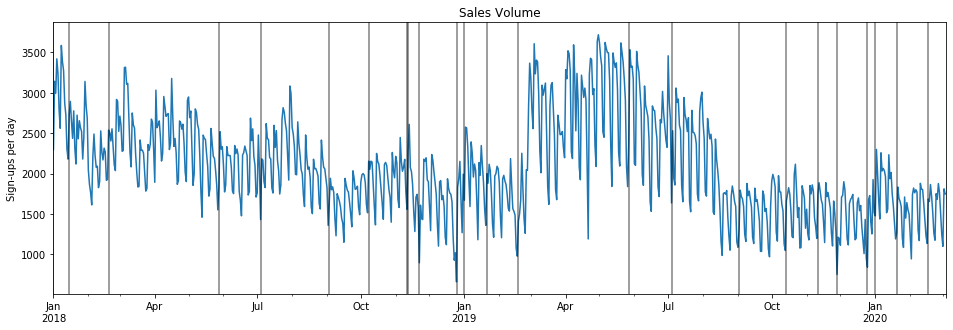

In [193]:
title='Sales Volume'
ylabel='Sign-ups per day'
xlabel='' # we don't really need a label here

ax = sequence_data_v2['Volume'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in sequence_data_v2.query('Is_Holiday==1').index:       # for days where holiday == 1
    ax.axvline(x=x, color='k', alpha = 0.5);

In [205]:
weekday=pd.get_dummies(sequence_data_v2['weekday'], prefix='wd')
sequence_data_v2=pd.concat([sequence_data_v2, weekday], axis=1)

In [206]:
sequence_data_v2.head(5)

Volume  VisitDate  weekday  Is_Holiday  wd_0  wd_1  wd_2  wd_3  \
Date                                                                         
2018-01-01  2299.0 2018-01-01        0           1     1     0     0     0   
2018-01-02  3143.0 2018-01-02        1           0     0     1     0     0   
2018-01-03  2994.0 2018-01-03        2           0     0     0     1     0   
2018-01-04  3421.0 2018-01-04        3           0     0     0     0     1   
2018-01-05  3241.0 2018-01-05        4           0     0     0     0     0   

            wd_4  wd_5  wd_6  
Date                          
2018-01-01     0     0     0  
2018-01-02     0     0     0  
2018-01-03     0     0     0  
2018-01-04     0     0     0  
2018-01-05     1     0     0

In [207]:
split_time=730
x_train_df = sequence_data_v2[:split_time]
x_valid_df = sequence_data_v2[split_time:]

In [208]:
# from pmdarima import auto_arima
# auto_arima(sequence_data_v2['Volume'], seasonal=True, m=7).summary()

In [209]:
# use double bracket for exogenous variable
# weekday variables not significant
auto_arima(sequence_data_v2['Volume'], exogenous=sequence_data_v2[['Is_Holiday',
                                                                  'wd_0', 'wd_1', 'wd_2', 'wd_3', 'wd_4', 'wd_5', 'wd_6']], seasonal=True, m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  794
Model:             SARIMAX(1, 1, 2)x(1, 0, 2, 7)   Log Likelihood               -5256.279
Date:                           Sun, 12 Apr 2020   AIC                          10544.558
Time:                                   10:50:36   BIC                          10619.372
Sample:                               01-01-2018   HQIC                         10573.310
                                    - 03-04-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0206      0.025     -0.814      0.416      -0.070       0.029
Is_Holiday  -486.2808     20.813    -23.364      0.000    -527.074    -445.487
wd_0         341.4478   8246.116      0.041      0.967   -1.58e+04    1.65e+04
wd_1         222.5020   8231.163      0.027      0.978   -1.59e+04    1.64e+04
wd_2         194.5814   8234.524      0.024      0.981   -1.59e+04    1.63e+04
wd_3         144.7201   8223.328      0.018      0.986    -1.6e+04    1.63e+04
wd_4           7.9804   8225.167      0.001      0.999   -1.61e+04    1.61e+04
wd_5        -390.5998   8229.125     -0.047      0.962   -1.65e+04    1.57e+04
wd_6        -520.6293   8230.759     -0.063      0.950   -1.67e+04    1.56e+04
ar.L1          0.8371      0.027     31.419      0.000       0.785       0.889
ma.L1         -1.0789      0.040    -26.776      0.000      -1.158      -1.000
ma.L2          0.0888      0.037      2.373      0.018       0.015       0.162
ar.S.L7        0.9026      0.035     25.984      0.000       0.835       0.971
ma.S.L7       -0.6290      0.050    -12.590      0.000      -0.727      -0.531
ma.S.L14      -0.0789      0.039     -2.042      0.041      -0.155      -0.003
sigma2      3.392e+04   1220.875     27.780      0.000    3.15e+04    3.63e+04
===================================================================================
Ljung-Box (Q):                       48.72   Jarque-Bera (JB):               200.67
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             0.20
Prob(H) (two-sided):                  0.47   Kurtosis:                         5.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [191]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [229]:
model = SARIMAX(x_train_df['Volume'], exog=x_train_df[['Is_Holiday']], order=(5,1,2), seasonal_order=(1,0,2,7), enforce_invertibility=False)

results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                            Volume   No. Observations:                  730
Model:             SARIMAX(5, 1, 2)x(1, 0, 2, 7)   Log Likelihood               -4932.521
Date:                           Sun, 12 Apr 2020   AIC                           9889.041
Time:                                   11:01:17   BIC                           9944.141
Sample:                               01-01-2018   HQIC                          9910.301
                                    - 12-31-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Is_Holiday  -212.5411     28.885     -7.358      0.000    -269.155    -155.927
ar.L1          0.8994      0.524      1.718      0.086      -0.127       1.926
ar.L2         -0.2095      0.465     -0.451      0.652      -1.120       0.701
ar.L3          0.1187      0.115      1.030      0.303      -0.107       0.345
ar.L4          0.0861      0.085      1.014      0.311      -0.080       0.253
ar.L5          0.0903      0.093      0.974      0.330      -0.091       0.272
ma.L1         -1.0240      0.521     -1.966      0.049      -2.045      -0.003
ma.L2          0.0241      0.515      0.047      0.963      -0.985       1.034
ar.S.L7        0.9998      0.000   6761.147      0.000       1.000       1.000
ma.S.L7       -0.7794      0.047    -16.605      0.000      -0.871      -0.687
ma.S.L14      -0.0899      0.047     -1.924      0.054      -0.181       0.002
sigma2      5.225e+04   3032.871     17.228      0.000    4.63e+04    5.82e+04
===================================================================================
Ljung-Box (Q):                       81.72   Jarque-Bera (JB):               229.90
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             0.09
Prob(H) (two-sided):                  0.26   Kurtosis:                         5.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.28e+14. Standard errors may be unstable.
"""

In [230]:
start=len(x_train_df)
end = len(x_train_df) + len(x_valid_df)-1

predictions = results.predict(start, end, exog=x_valid_df[['Is_Holiday' ]], typ='levels').rename('SARIMAX with Exog')

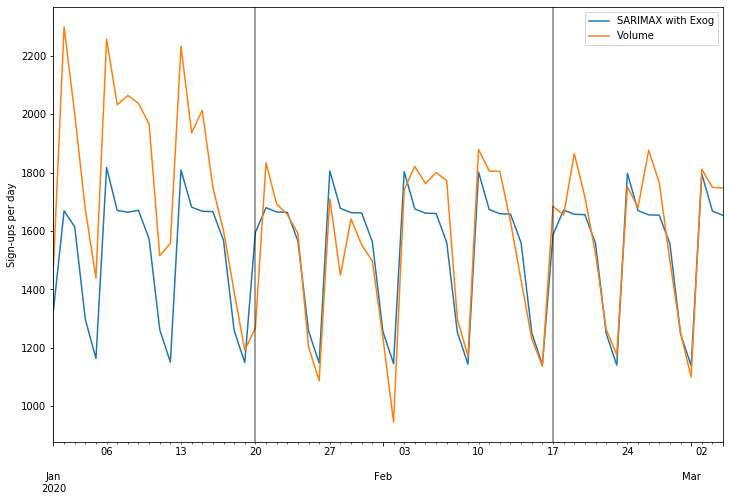

In [231]:
ax = predictions.plot(figsize=(12,8), legend=True)
x_valid_df['Volume'].plot(legend=True)

ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in x_valid_df.query('Is_Holiday==1').index:       # for days where holiday == 1
    ax.axvline(x=x, color='k', alpha = 0.5);

In [232]:
from statsmodels.tools.eval_measures import rmse

error = rmse(x_valid_df['Volume'], predictions)
print("RMSE of first SARIMA Model:", error)

RMSE of first SARIMA Model: 207.29395192605543


__Retrain model and forecast into the future__

In [287]:
# retrain the model on the whole dataset and forecast into the future

model = SARIMAX(sequence_data_v2['Volume'], exog=sequence_data_v2[['Is_Holiday']], order=(5,1,2), seasonal_order=(1,0,2,7), enforce_invertibility=False)

results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                            Volume   No. Observations:                  794
Model:             SARIMAX(5, 1, 2)x(1, 0, 2, 7)   Log Likelihood               -5384.065
Date:                           Sun, 12 Apr 2020   AIC                          10792.130
Time:                                   12:11:20   BIC                          10848.240
Sample:                               01-01-2018   HQIC                         10813.694
                                    - 03-04-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Is_Holiday  -197.5210     39.142     -5.046      0.000    -274.237    -120.805
ar.L1         -0.2788      0.784     -0.356      0.722      -1.816       1.258
ar.L2          0.7368      0.571      1.291      0.197      -0.382       1.855
ar.L3          0.0544      0.083      0.655      0.512      -0.108       0.217
ar.L4          0.1080      0.063      1.727      0.084      -0.015       0.231
ar.L5          0.0775      0.099      0.780      0.435      -0.117       0.272
ma.L1         -0.0039      0.786     -0.005      0.996      -1.544       1.536
ma.L2         -0.9936      0.783     -1.269      0.204      -2.528       0.541
ar.S.L7        0.9828      0.010     93.953      0.000       0.962       1.003
ma.S.L7       -0.6889      0.065    -10.571      0.000      -0.817      -0.561
ma.S.L14      -0.0671      0.068     -0.988      0.323      -0.200       0.066
sigma2      7.427e+04   4929.025     15.067      0.000    6.46e+04    8.39e+04
===================================================================================
Ljung-Box (Q):                       41.13   Jarque-Bera (JB):               261.31
Prob(Q):                              0.42   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                             0.23
Prob(H) (two-sided):                  0.46   Kurtosis:                         5.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

__need to prepare a dataframe that has the exogenous variables and missing on the label variable__

In [297]:
# another way of creating this dataframe

idx = pd.date_range('2020-03-05', periods=31, freq='D')

df_forecast = pd.DataFrame(index=idx)
df_forecast

DatetimeIndex(['2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
               '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12',
               '2020-03-13', '2020-03-14', '2020-03-15', '2020-03-16',
               '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20',
               '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-24',
               '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28',
               '2020-03-29', '2020-03-30', '2020-03-31', '2020-04-01',
               '2020-04-02', '2020-04-03', '2020-04-04'],
              dtype='datetime64[ns]', freq='D')


In [247]:
from datetime import datetime, timedelta

start_date = pd.to_datetime('2020-03-05',format='%Y-%m-%d')
days = pd.date_range(start_date, start_date + timedelta(30), freq='D')

print(days)

DatetimeIndex(['2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
               '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12',
               '2020-03-13', '2020-03-14', '2020-03-15', '2020-03-16',
               '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20',
               '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-24',
               '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28',
               '2020-03-29', '2020-03-30', '2020-03-31', '2020-04-01',
               '2020-04-02', '2020-04-03', '2020-04-04'],
              dtype='datetime64[ns]', freq='D')


In [252]:
future=pd.DataFrame(index=days)

future['VisitDate']=future.index

In [253]:
future['Is_Holiday']=[1 if str(val).split()[0] in us_holidays else 0 for val in future['VisitDate']]

In [254]:
future.head(5)

VisitDate  Is_Holiday
2020-03-05 2020-03-05           0
2020-03-06 2020-03-06           0
2020-03-07 2020-03-07           0
2020-03-08 2020-03-08           0
2020-03-09 2020-03-09           0

In [283]:
# concat function lines vertically by column name
sequence_data_v3=pd.concat([sequence_data_v2, future], axis=0)
print(sequence_data_v3.shape)

(825, 11)


In [288]:
exog_forecast=sequence_data_v3[794:][['Is_Holiday']]

# future_data.head(5)
print(exog_forecast.shape)

(31, 1)


In [290]:
fcast=results.predict(start=len(sequence_data_v2),end=len(sequence_data_v2)+30,                                                                   exog=exog_forecast).rename('Forecast into future')

In [291]:
fcast

2020-03-05    1691.409941
2020-03-06    1543.768046
2020-03-07    1292.567283
2020-03-08    1167.065653
2020-03-09    1789.934928
2020-03-10    1708.618237
2020-03-11    1767.047681
2020-03-12    1710.266305
2020-03-13    1566.446564
2020-03-14    1312.211313
2020-03-15    1192.830697
2020-03-16    1796.917772
2020-03-17    1714.610724
2020-03-18    1777.366722
2020-03-19    1720.605937
2020-03-20    1577.647861
2020-03-21    1326.925579
2020-03-22    1208.985773
2020-03-23    1802.472738
2020-03-24    1720.901999
2020-03-25    1782.347839
2020-03-26    1725.983797
2020-03-27    1585.358752
2020-03-28    1338.443116
2020-03-29    1222.467867
2020-03-30    1805.335136
2020-03-31    1725.157269
2020-04-01    1785.163603
2020-04-02    1729.800570
2020-04-03    1591.243426
2020-04-04    1348.630505
Freq: D, Name: Forecast into future, dtype: float64

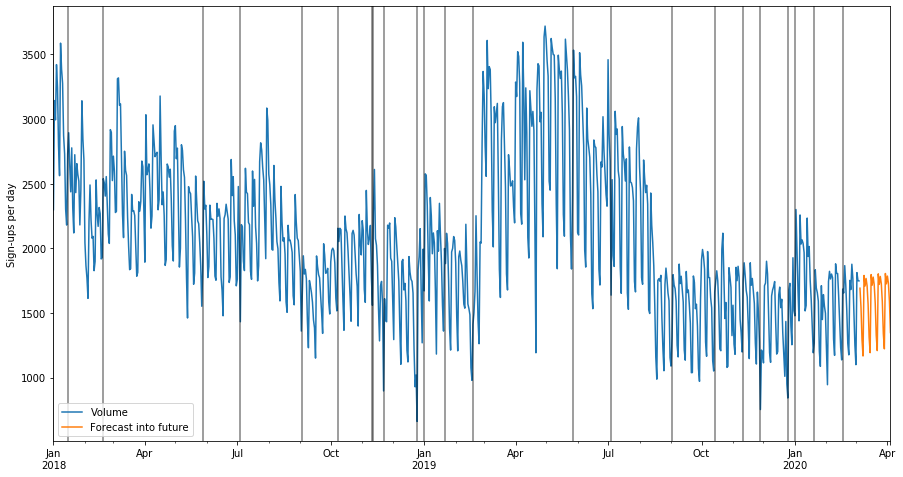

In [294]:
ax=sequence_data_v2['Volume'].plot(figsize=(15,8), legend=True)
fcast.plot(legend=True)

ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in sequence_data_v3.query('Is_Holiday==1').index:       # for days where holiday == 1
    ax.axvline(x=x, color='k', alpha = 0.5);

# Facebook Prophet Library

By default, prophet expects daily data and the column names have tobe ds and y. 

In [310]:
from fbprophet import Prophet

In [299]:
sequence_data.columns

Index(['Volume', 'VisitDate', 'weekday', 'Is_Holiday', 'wd_0', 'wd_1', 'wd_2',
       'wd_3', 'wd_4', 'wd_5', 'wd_6'],
      dtype='object')

In [300]:
df=sequence_data[['VisitDate','Volume']]
df.columns

Index(['VisitDate', 'Volume'], dtype='object')

In [301]:
df.columns = ['ds','y']

In [302]:
df.dtypes

ds    datetime64[ns]
y            float32
dtype: object

In [304]:
df.reset_index(inplace=True)

In [308]:
df.drop(['Date'], axis=1, inplace=True)

In [341]:
pd.plotting.register_matplotlib_converters()

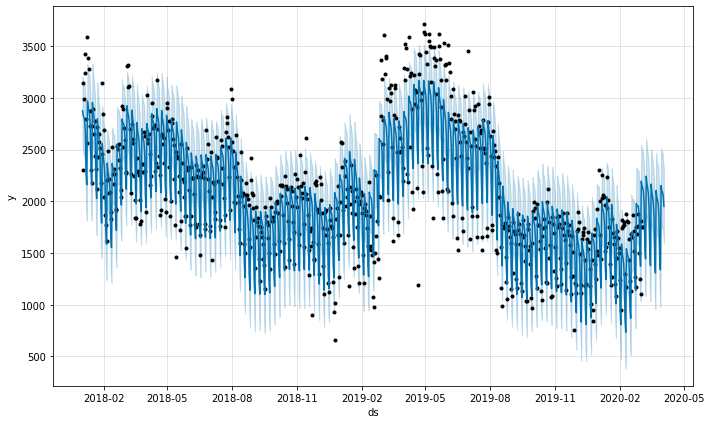

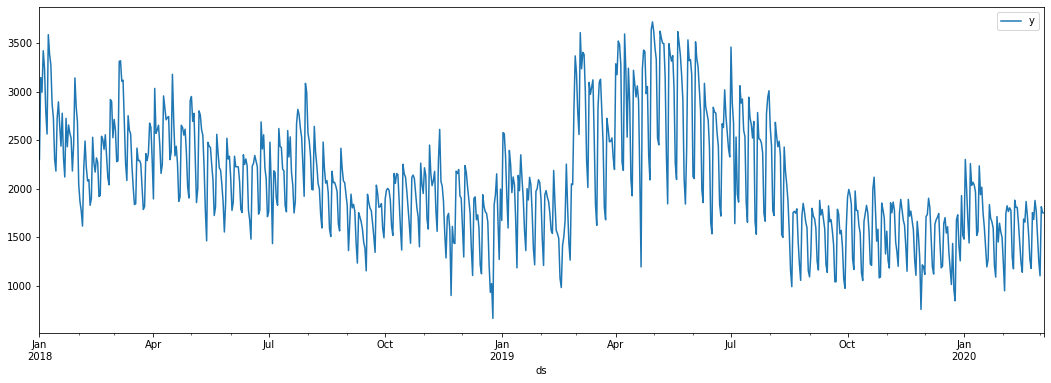

In [385]:
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=30,freq='D')
forecast = m.predict(future)
fig = m.plot(forecast)
df.plot(x='ds',y='y',figsize=(18,6));

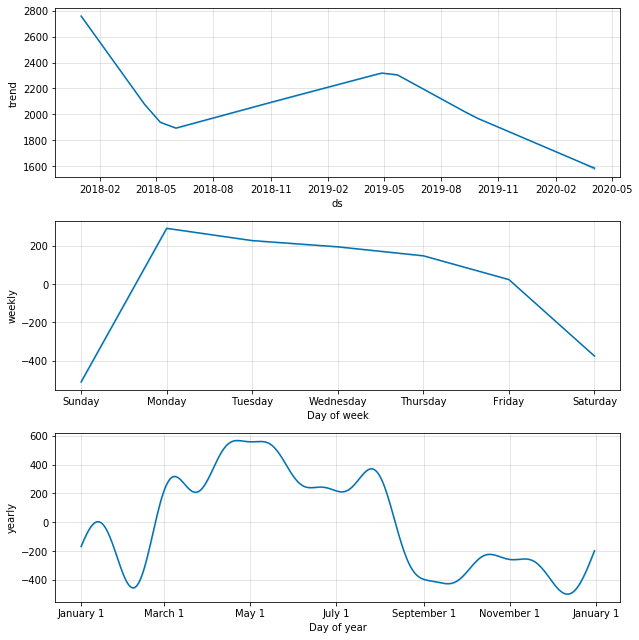

In [383]:
m.plot_components(forecast);

### Show Trend Changepoints

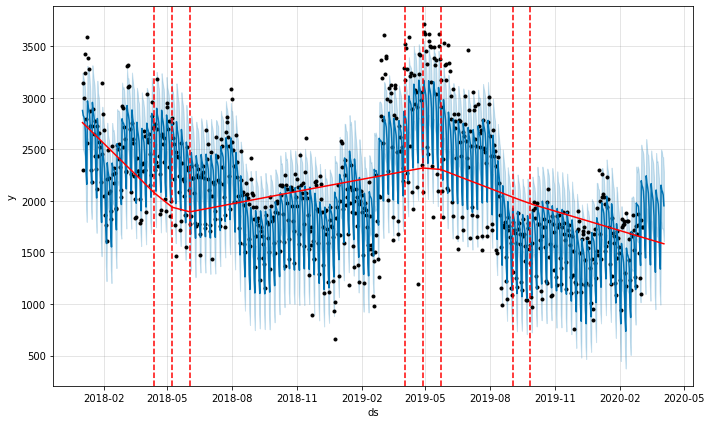

In [384]:
# m = Prophet()
# m.fit(df)
# future = m.make_future_dataframe(periods=30,freq='D')
# forecast = m.predict(future)


from fbprophet.plot import add_changepoints_to_plot
fig=m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

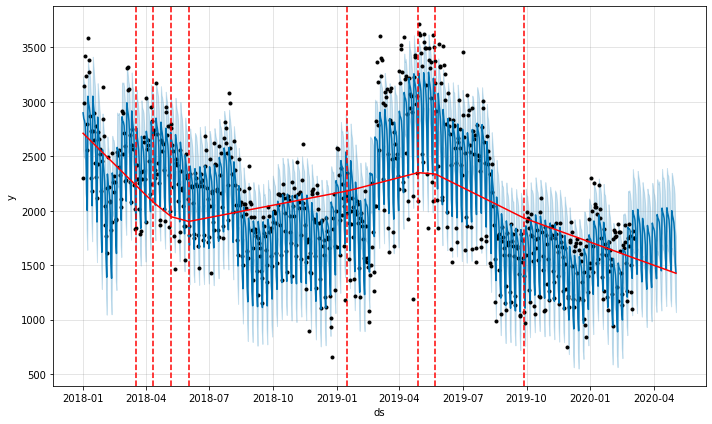

In [390]:
m = Prophet(seasonality_mode='multiplicative')
m.fit(df)
future = m.make_future_dataframe(periods=60,freq='D')
forecast = m.predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

### Manual Cross-validation

In [394]:
train=df.iloc[:730]
test=df.iloc[730:]

In [371]:
print(test.shape)

(64, 2)


In [395]:
m=Prophet(seasonality_mode='multiplicative')
m.fit(train)

future = m.make_future_dataframe(periods=64, freq='D')

forecast=m.predict(future)

In [377]:
forecast.iloc[730:740][['ds','yhat_lower','yhat_upper','yhat']]

ds  yhat_lower   yhat_upper         yhat
730 2020-01-01  890.086378  1747.543577  1320.671113
731 2020-01-02  819.770206  1687.661843  1260.165978
732 2020-01-03  696.168381  1564.072373  1132.237587
733 2020-01-04  255.510717  1134.749827   719.953559
734 2020-01-05  127.375703  1013.856117   579.852939
735 2020-01-06  952.418025  1819.955074  1390.557957
736 2020-01-07  900.413970  1747.790541  1318.906420
737 2020-01-08  847.342867  1695.484486  1271.491602
738 2020-01-09  802.945821  1621.441599  1210.986467
739 2020-01-10  657.328360  1480.419335  1083.058076

In [378]:
test.head(10)

ds       y
730 2020-01-01  1478.0
731 2020-01-02  2300.0
732 2020-01-03  2002.0
733 2020-01-04  1674.0
734 2020-01-05  1439.0
735 2020-01-06  2258.0
736 2020-01-07  2033.0
737 2020-01-08  2065.0
738 2020-01-09  2038.0
739 2020-01-10  1967.0

In [375]:
# forecast.iloc[730:]['yhat']

from statsmodels.tools.eval_measures import rmse

error = rmse(test['y'], forecast.iloc[730:]['yhat'])
print("RMSE of fbprophet:", error)

RMSE of fbprophet: 747.2461853371695


In [347]:
# forecast.plot(x='ds', y='yhat', figsize=(15,6));

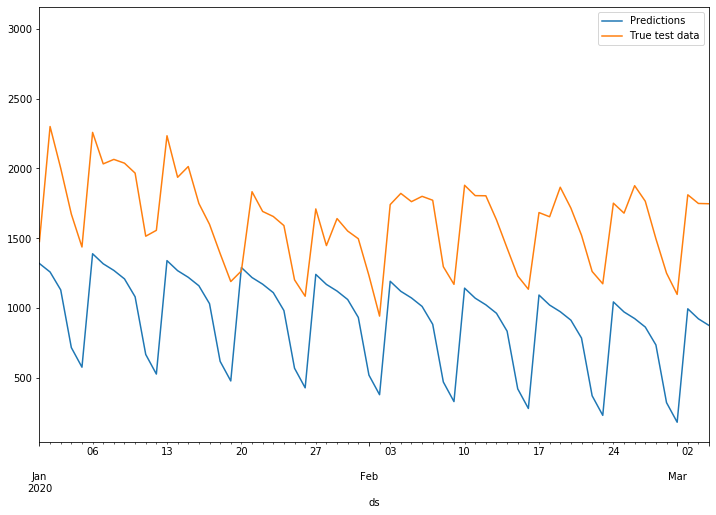

In [349]:
ax = forecast.plot(x='ds', y='yhat', label='Predictions', legend=True, figsize=(12,8))
test.plot(x='ds', y='y', label='True test data', legend=True, ax=ax,xlim=('2020-01-01','2020-03-04'));

### prophet cross-validation

In [351]:
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [352]:
# INITIAL
initial=1*365
initial = str(initial) + ' days'

In [353]:
# PERIOD
period=1*365
period = str(period) +' days'

In [356]:
# HORIZON

horizon=60
horizon=str(horizon) + ' days'

In [357]:
df_cv=cross_validation(m, initial=initial, period=period, horizon=horizon)

In [358]:
df_cv.shape

(60, 6)

In [360]:
df_cv.head(10)

ds         yhat   yhat_lower   yhat_upper       y     cutoff
0 2019-11-02   845.139017   427.917534  1256.033498  1259.0 2019-11-01
1 2019-11-03   700.857906   305.808572  1109.209586  1180.0 2019-11-01
2 2019-11-04  1531.470869  1087.582355  1959.845979  1853.0 2019-11-01
3 2019-11-05  1461.405235  1046.929978  1849.565677  1750.0 2019-11-01
4 2019-11-06  1411.423451  1003.362237  1808.617170  1861.0 2019-11-01
5 2019-11-07  1343.101450   924.868079  1764.424419  1778.0 2019-11-01
6 2019-11-08  1210.871268   806.276927  1625.522608  1450.0 2019-11-01
7 2019-11-09   775.036060   367.061425  1204.643587  1348.0 2019-11-01
8 2019-11-10   630.754950   273.265400  1051.412809  1198.0 2019-11-01
9 2019-11-11  1461.367913  1068.486572  1853.747833  1747.0 2019-11-01

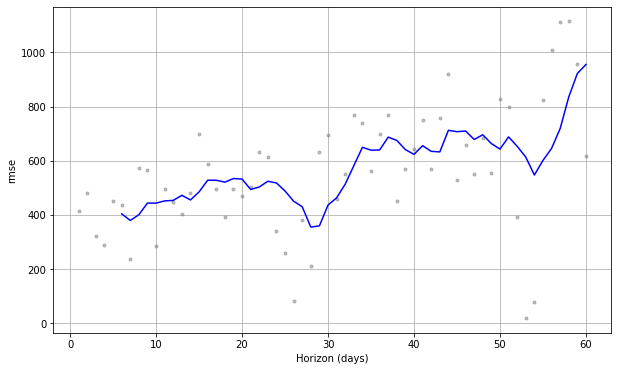

In [364]:
# performance_metrics(df_cv)
plot_cross_validation_metric(df_cv, metric='rmse');

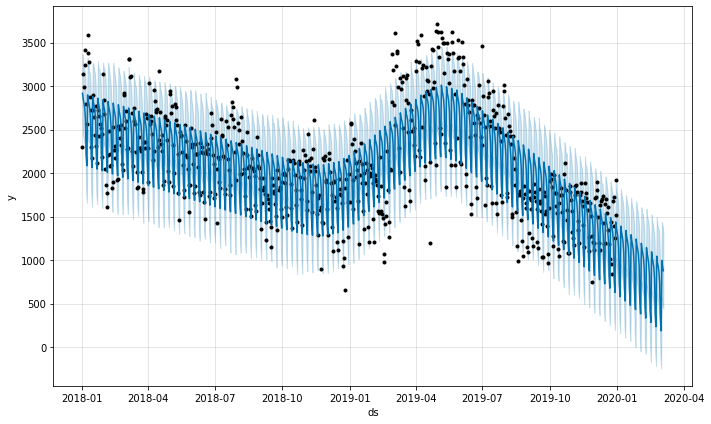

In [350]:
m.plot(forecast);

# Neural Network Models

## Function to Produce Windowed Dataset

In [8]:
# add a random seed within the function to be able to reproduce
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
      tf.random.set_seed(345)
      dataset = tf.data.Dataset.from_tensor_slices(series)
      dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
      dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
      dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
      dataset = dataset.batch(batch_size).prefetch(1)
      return dataset

In [479]:
batch_size=32

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

for window_dataset in dataset:
    for val in window_dataset:
      print(val.numpy(), end=" ")
      print()

[2299. 3143. 2994. 3421. 3241. 2793. 2562. 3587. 3384. 3276. 2872. 2730.
 2302. 2180. 2731. 2894.] 
[3143. 2994. 3421. 3241. 2793. 2562. 3587. 3384. 3276. 2872. 2730. 2302.
 2180. 2731. 2894. 2650.] 
[2994. 3421. 3241. 2793. 2562. 3587. 3384. 3276. 2872. 2730. 2302. 2180.
 2731. 2894. 2650. 2437.] 
[3421. 3241. 2793. 2562. 3587. 3384. 3276. 2872. 2730. 2302. 2180. 2731.
 2894. 2650. 2437. 2777.] 
[3241. 2793. 2562. 3587. 3384. 3276. 2872. 2730. 2302. 2180. 2731. 2894.
 2650. 2437. 2777. 2314.] 
[2793. 2562. 3587. 3384. 3276. 2872. 2730. 2302. 2180. 2731. 2894. 2650.
 2437. 2777. 2314. 2119.] 
[2562. 3587. 3384. 3276. 2872. 2730. 2302. 2180. 2731. 2894. 2650. 2437.
 2777. 2314. 2119. 2724.] 
[3587. 3384. 3276. 2872. 2730. 2302. 2180. 2731. 2894. 2650. 2437. 2777.
 2314. 2119. 2724. 2431.] 
[3384. 3276. 2872. 2730. 2302. 2180. 2731. 2894. 2650. 2437. 2777. 2314.
 2119. 2724. 2431. 2655.] 
[3276. 2872. 2730. 2302. 2180. 2731. 2894. 2650. 2437. 2777. 2314. 2119.
 2724. 2431. 2655. 2571.] 


 2559. 2370. 2213. 2190.] 
[2549. 2217. 1770. 1461. 2477. 2437. 2423. 2246. 2090. 1722. 1809. 2559.
 2370. 2213. 2190. 2044.] 
[2217. 1770. 1461. 2477. 2437. 2423. 2246. 2090. 1722. 1809. 2559. 2370.
 2213. 2190. 2044. 1863.] 
[1770. 1461. 2477. 2437. 2423. 2246. 2090. 1722. 1809. 2559. 2370. 2213.
 2190. 2044. 1863. 1552.] 
[1461. 2477. 2437. 2423. 2246. 2090. 1722. 1809. 2559. 2370. 2213. 2190.
 2044. 1863. 1552. 1859.] 
[2477. 2437. 2423. 2246. 2090. 1722. 1809. 2559. 2370. 2213. 2190. 2044.
 1863. 1552. 1859. 2519.] 
[2437. 2423. 2246. 2090. 1722. 1809. 2559. 2370. 2213. 2190. 2044. 1863.
 1552. 1859. 2519. 2304.] 
[2423. 2246. 2090. 1722. 1809. 2559. 2370. 2213. 2190. 2044. 1863. 1552.
 1859. 2519. 2304. 2333.] 
[2246. 2090. 1722. 1809. 2559. 2370. 2213. 2190. 2044. 1863. 1552. 1859.
 2519. 2304. 2333. 2108.] 
[2090. 1722. 1809. 2559. 2370. 2213. 2190. 2044. 1863. 1552. 1859. 2519.
 2304. 2333. 2108. 1774.] 
[1722. 1809. 2559. 2370. 2213. 2190. 2044. 1863. 1552. 1859. 2519. 2304.


 1807. 1814. 1845. 1587.] 
[1385. 1151. 1941. 1859. 1797. 1772. 1644. 1502. 1342. 2035. 1949. 1807.
 1814. 1845. 1587. 1492.] 
[1151. 1941. 1859. 1797. 1772. 1644. 1502. 1342. 2035. 1949. 1807. 1814.
 1845. 1587. 1492. 1896.] 
[1941. 1859. 1797. 1772. 1644. 1502. 1342. 2035. 1949. 1807. 1814. 1845.
 1587. 1492. 1896. 1985.] 
[1859. 1797. 1772. 1644. 1502. 1342. 2035. 1949. 1807. 1814. 1845. 1587.
 1492. 1896. 1985. 2001.] 
[1797. 1772. 1644. 1502. 1342. 2035. 1949. 1807. 1814. 1845. 1587. 1492.
 1896. 1985. 2001. 1982.] 
[1772. 1644. 1502. 1342. 2035. 1949. 1807. 1814. 1845. 1587. 1492. 1896.
 1985. 2001. 1982. 1886.] 
[1644. 1502. 1342. 2035. 1949. 1807. 1814. 1845. 1587. 1492. 1896. 1985.
 2001. 1982. 1886. 1614.] 
[1502. 1342. 2035. 1949. 1807. 1814. 1845. 1587. 1492. 1896. 1985. 2001.
 1982. 1886. 1614. 1516.] 
[1342. 2035. 1949. 1807. 1814. 1845. 1587. 1492. 1896. 1985. 2001. 1982.
 1886. 1614. 1516. 2155.] 
[2035. 1949. 1807. 1814. 1845. 1587. 1492. 1896. 1985. 2001. 1982. 1886.


 1865. 1743. 1569. 1537.] 
[1213. 1972. 2000. 2091. 2061. 1890. 1477. 1207. 1935. 1979. 1910. 1865.
 1743. 1569. 1537. 2186.] 
[1972. 2000. 2091. 2061. 1890. 1477. 1207. 1935. 1979. 1910. 1865. 1743.
 1569. 1537. 2186. 1856.] 
[2000. 2091. 2061. 1890. 1477. 1207. 1935. 1979. 1910. 1865. 1743. 1569.
 1537. 2186. 1856. 1569.] 
[2091. 2061. 1890. 1477. 1207. 1935. 1979. 1910. 1865. 1743. 1569. 1537.
 2186. 1856. 1569. 1534.] 
[2061. 1890. 1477. 1207. 1935. 1979. 1910. 1865. 1743. 1569. 1537. 2186.
 1856. 1569. 1534. 1486.] 
[1890. 1477. 1207. 1935. 1979. 1910. 1865. 1743. 1569. 1537. 2186. 1856.
 1569. 1534. 1486. 1076.] 
[1477. 1207. 1935. 1979. 1910. 1865. 1743. 1569. 1537. 2186. 1856. 1569.
 1534. 1486. 1076.  979.] 
[1207. 1935. 1979. 1910. 1865. 1743. 1569. 1537. 2186. 1856. 1569. 1534.
 1486. 1076.  979. 1413.] 
[1935. 1979. 1910. 1865. 1743. 1569. 1537. 2186. 1856. 1569. 1534. 1486.
 1076.  979. 1413. 1502.] 
[1979. 1910. 1865. 1743. 1569. 1537. 2186. 1856. 1569. 1534. 1486. 1076.


 2838. 2789. 2779. 2573.] 
[3019. 2793. 1985. 1855. 3085. 2846. 2779. 2703. 2419. 1649. 1533. 2838.
 2789. 2779. 2573. 2437.] 
[2793. 1985. 1855. 3085. 2846. 2779. 2703. 2419. 1649. 1533. 2838. 2789.
 2779. 2573. 2437. 1839.] 
[1985. 1855. 3085. 2846. 2779. 2703. 2419. 1649. 1533. 2838. 2789. 2779.
 2573. 2437. 1839. 1716.] 
[1855. 3085. 2846. 2779. 2703. 2419. 1649. 1533. 2838. 2789. 2779. 2573.
 2437. 1839. 1716. 2668.] 
[3085. 2846. 2779. 2703. 2419. 1649. 1533. 2838. 2789. 2779. 2573. 2437.
 1839. 1716. 2668. 2629.] 
[2846. 2779. 2703. 2419. 1649. 1533. 2838. 2789. 2779. 2573. 2437. 1839.
 1716. 2668. 2629. 3018.] 
[2779. 2703. 2419. 1649. 1533. 2838. 2789. 2779. 2573. 2437. 1839. 1716.
 2668. 2629. 3018. 2749.] 
[2703. 2419. 1649. 1533. 2838. 2789. 2779. 2573. 2437. 1839. 1716. 2668.
 2629. 3018. 2749. 2576.] 
[2419. 1649. 1533. 2838. 2789. 2779. 2573. 2437. 1839. 1716. 2668. 2629.
 3018. 2749. 2576. 2417.] 
[1649. 1533. 2838. 2789. 2779. 2573. 2437. 1839. 1716. 2668. 2629. 3018.


 1850. 1780. 1697. 1325.] 
[1749. 1548. 1222. 1208. 1992. 2117. 1803. 1457. 1581. 1079. 1087. 1850.
 1780. 1697. 1325. 1560.] 
[1548. 1222. 1208. 1992. 2117. 1803. 1457. 1581. 1079. 1087. 1850. 1780.
 1697. 1325. 1560. 1259.] 
[1222. 1208. 1992. 2117. 1803. 1457. 1581. 1079. 1087. 1850. 1780. 1697.
 1325. 1560. 1259. 1180.] 
[1208. 1992. 2117. 1803. 1457. 1581. 1079. 1087. 1850. 1780. 1697. 1325.
 1560. 1259. 1180. 1853.] 
[1992. 2117. 1803. 1457. 1581. 1079. 1087. 1850. 1780. 1697. 1325. 1560.
 1259. 1180. 1853. 1750.] 
[2117. 1803. 1457. 1581. 1079. 1087. 1850. 1780. 1697. 1325. 1560. 1259.
 1180. 1853. 1750. 1861.] 
[1803. 1457. 1581. 1079. 1087. 1850. 1780. 1697. 1325. 1560. 1259. 1180.
 1853. 1750. 1861. 1778.] 
[1457. 1581. 1079. 1087. 1850. 1780. 1697. 1325. 1560. 1259. 1180. 1853.
 1750. 1861. 1778. 1450.] 
[1581. 1079. 1087. 1850. 1780. 1697. 1325. 1560. 1259. 1180. 1853. 1750.
 1861. 1778. 1450. 1348.] 
[1079. 1087. 1850. 1780. 1697. 1325. 1560. 1259. 1180. 1853. 1750. 1861.


###  Time Series Generator

This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

#### Arguments
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [61]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [62]:
n_input = 2
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

NameError: name 'scaled_train' is not defined

In [ ]:
I have not figure out how to use the TimeSeriesGenerator with the rest of the code but by itself it works fine

### Single Layer NN

Smaller batch sizes fit better for time series data

In [25]:
batch_size=6
window_size=15

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
# print(dataset)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size]) #this is equivalent to regression
single_layer_model = tf.keras.models.Sequential([l0])


single_layer_model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.70))
single_layer_model.fit(dataset,epochs=100,verbose=0)

print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[-0.21043043],
       [ 0.36677456],
       [ 0.02749676],
       [-0.05032167],
       [-0.01405648],
       [-0.02613634],
       [-0.06523166],
       [-0.32168996],
       [ 0.4777198 ],
       [ 0.03969267],
       [ 0.04698905],
       [ 0.00457188],
       [ 0.02983775],
       [ 0.00196204],
       [ 0.6896479 ]], dtype=float32), array([0.00346386], dtype=float32)]


In [26]:
slm_forecast = []

for time in range(len(series) - window_size):
    slm_forecast.append(single_layer_model.predict(series[time:time + window_size][np.newaxis]))

slm_forecast = slm_forecast[split_time-window_size:]
slm_results = np.array(slm_forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

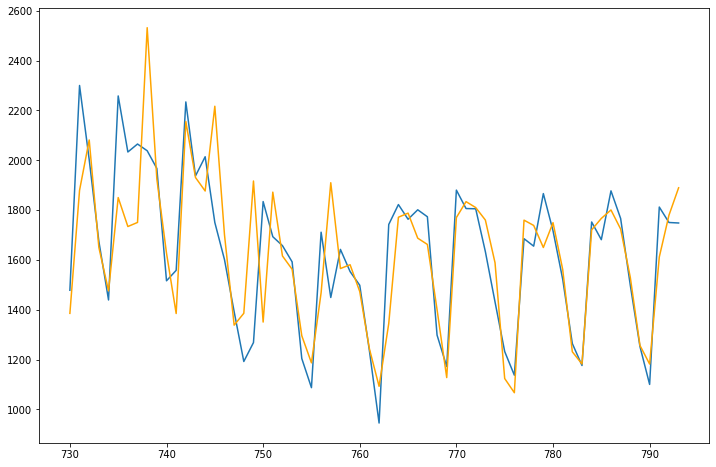

In [27]:
plt.plot(time_valid, x_valid)
plt.plot(time_valid, slm_results, color='orange');

In [28]:
tf.keras.metrics.mean_absolute_error(x_valid, slm_results).numpy()

136.80173

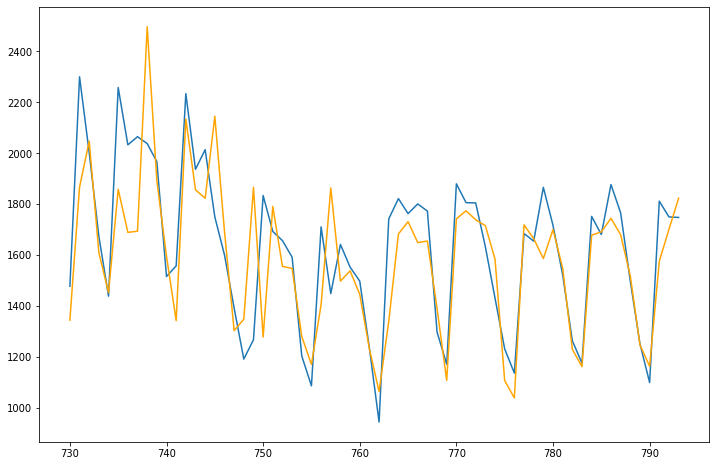

In [75]:
plt.plot(time_valid, x_valid)
plt.plot(time_valid, slm_results, color='orange');

In [59]:
tf.keras.metrics.mean_absolute_error(x_valid, slm_results).numpy()

143.79492

__single layer DNN with scaled data__

Scaling the data and run the NN doesn't give a bit improvement!!! 

In [68]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()

In [74]:
scaler.fit(x_train_df)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [92]:
scaled_x_train=scaler.transform(x_train_df)
scaled_x_valid=scaler.transform(x_valid_df)

In [ ]:
sequence_data['scaled_volume']=np.vstack((scaled_x_train, scaled_x_valid))

In [77]:
scaled_x_train=np.reshape(scaled_x_train, (730,))
scaled_x_valid=np.reshape(scaled_x_valid,(64,))

In [106]:
scaled_x_train.shape

(730, 1)

In [98]:
sequence_data.head(3)

Volume  scaled_volume
Date                             
2008-01-01  2299.0       0.535644
2008-01-02  3143.0       0.811642
2008-01-03  2994.0       0.762917

In [100]:
series=np.array(sequence_data['scaled_volume'])

In [82]:
batch_size=6
window_size=15

dataset = windowed_dataset(scaled_x_train, window_size, batch_size, shuffle_buffer_size)
# print(dataset)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size]) #this is equivalent to regression
single_layer_model = tf.keras.models.Sequential([l0])


single_layer_model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.70))
single_layer_model.fit(dataset,epochs=100,verbose=0)

print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[ 0.41059405],
       [-0.22928923],
       [ 0.4683094 ],
       [ 0.42031735],
       [ 0.49847543],
       [-0.50431025],
       [ 0.5779815 ],
       [ 0.29585946],
       [ 0.05420454],
       [-0.5832525 ],
       [ 0.4818739 ],
       [ 0.6111675 ],
       [-0.16085854],
       [-0.34292072],
       [ 0.07509336]], dtype=float32), array([-0.00041764], dtype=float32)]


In [101]:
slm_forecast = []

for time in range(len(series) - window_size):
    slm_forecast.append(single_layer_model.predict(series[time:time + window_size][np.newaxis]))

slm_forecast = slm_forecast[split_time-window_size:]
slm_results = np.array(slm_forecast)[:, 0, 0]
# plt.figure(figsize=(10, 6))

In [105]:
true_predictions=scaler.inverse_transform(np.reshape(slm_results,(64,1)))

In [113]:
# np.reshape(true_predictions,(64,))

tf.keras.metrics.mean_absolute_error(x_valid, np.reshape(true_predictions,(64,))).numpy()

1059.0747

### DNN

In [33]:
batch_size=32

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


dnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

#change momentum improves accuracy
#adam didn't work as well
dnn_model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.90), metrics=["mae"]) 
history = dnn_model.fit(dataset,epochs=50,verbose=1)

Epoch 1/50
23/23 [==============================] - 1s 31ms/step - loss: 907358.9246 - mae: 732.2596
Epoch 2/50
23/23 [==============================] - 0s 9ms/step - loss: 136549.1747 - mae: 282.8224
Epoch 3/50
23/23 [==============================] - 0s 9ms/step - loss: 89126.7567 - mae: 225.3262
Epoch 4/50
23/23 [==============================] - 0s 10ms/step - loss: 114686.2063 - mae: 269.6644
Epoch 5/50
23/23 [==============================] - 0s 10ms/step - loss: 84910.6760 - mae: 221.4468
Epoch 6/50
23/23 [==============================] - 0s 9ms/step - loss: 74499.8655 - mae: 209.2458
Epoch 7/50
23/23 [==============================] - 0s 9ms/step - loss: 113970.0079 - mae: 268.1501
Epoch 8/50
23/23 [==============================] - 0s 9ms/step - loss: 72591.6065 - mae: 200.0304
Epoch 9/50
23/23 [==============================] - 0s 9ms/step - loss: 68993.3405 - mae: 199.1578
Epoch 10/50
23/23 [==============================] - 0s 9ms/step - loss: 72851.5478 - mae: 200.9249
Ep

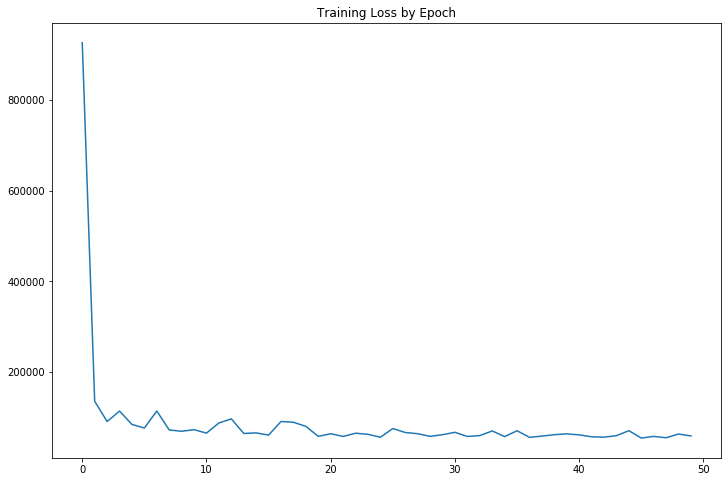

In [34]:
plt.title("Training Loss by Epoch")
plt.plot(history.history["loss"]);

<Figure size 720x432 with 0 Axes>

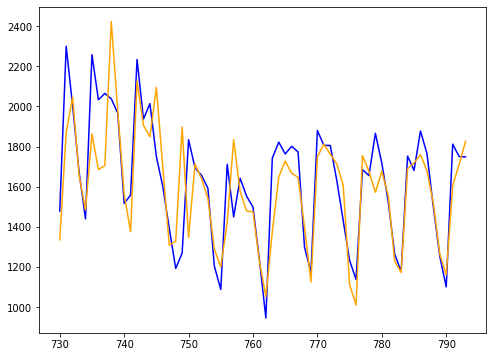

In [35]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(dnn_model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plt.figure(figsize=(8,6))
plt.plot(time_valid, x_valid, color='blue')
plt.plot(time_valid, results,color='orange');

In [109]:
valid_df=pd.DataFrame()

valid_df['time']=time_valid
valid_df['actual']=x_valid
valid_df['slm_forecast']=slm_results
valid_df['dnn_forecast']=results

In [110]:
valid_df.head(10)

time  actual  slm_forecast  dnn_forecast
0  730.0  1478.0   1344.923096   1334.735596
1  731.0  2300.0   1867.129395   1870.618042
2  732.0  2002.0   2047.578003   2046.593994
3  733.0  1674.0   1609.461182   1656.476685
4  734.0  1439.0   1453.238525   1483.505371
5  735.0  2258.0   1858.509033   1863.263794
6  736.0  2033.0   1689.378662   1684.918457
7  737.0  2065.0   1694.007202   1704.345825
8  738.0  2038.0   2496.677979   2423.642578
9  739.0  1967.0   1892.706299   1979.877563

In [32]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
# EXPECTED OUTPUT
# A Value less than 3

194.87686

In [113]:
# valid_df.tail(15)['actual']
# print("MAE of Moving Average Forecast:", tf.keras.metrics.mean_absolute_error(valid_df.tail(30)['actual'], valid_df.tail(30)['moving_average']).numpy())
print("MAE of DNN Forecast:", tf.keras.metrics.mean_absolute_error(valid_df.tail(30)['actual'], valid_df.tail(30)['dnn_forecast']).numpy())
print("MAE of single layer model:", tf.keras.metrics.mean_absolute_error(valid_df.tail(30)['actual'], valid_df.tail(30)['slm_forecast']).numpy())

MAE of DNN Forecast: 83.939804
MAE of single layer model: 81.778206


### Use Learning Rate Scheduler to Find the Optimal LR

In [114]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20)
)

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9))
history = model.fit(dataset, epochs=50, callbacks=[lr_schedule], verbose=0)

In [33]:
# for i in np.arange(50)/20:
#     print(1e-8*10 ** i)

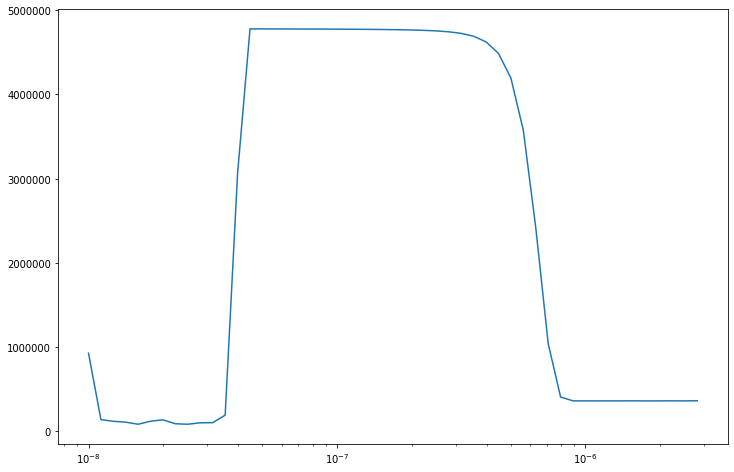

In [115]:
lrs = 1e-8 * (10 ** (np.arange(50) / 20))
plt.semilogx(lrs, history.history["loss"])
# plt.axis([1e-8, 1e-3, 0, 500])

In [35]:
import pandas as pd
history_df=pd.DataFrame()
history_df['lr']=lrs
history_df['loss']=history.history['loss']

In [36]:
history_df.head(10)

lr          loss
0  1.000000e-08  1.254848e+06
1  1.122018e-08  3.742195e+05
2  1.258925e-08  1.908132e+05
3  1.412538e-08  1.543709e+05
4  1.584893e-08  1.049828e+05
5  1.778279e-08  9.044160e+04
6  1.995262e-08  8.495667e+04
7  2.238721e-08  8.561282e+04
8  2.511886e-08  8.689866e+04
9  2.818383e-08  9.109083e+04

In [38]:
history_df['loss'].min()
print(history_df[history_df.loss == history_df.loss.min()]) 

              lr          loss
10  3.162278e-08  80606.148661


### Train w Huber Loss

In [ ]:
# the optimal learning rate didn't work well
# Huber loss is less sensitive to outliers
# MAE much larger with Huber loss

In [118]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

#change momentum improves accuracy
#adam didn't work as well
model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9), metrics=["mae"]) 
history = model.fit(dataset,epochs=1000,verbose=1)

Epoch 1/1000
23/23 [==============================] - 0s 20ms/step - loss: 2320.1362 - mae: 2318.7886
Epoch 2/1000
23/23 [==============================] - 0s 8ms/step - loss: 2249.8688 - mae: 2249.8457
Epoch 3/1000
23/23 [==============================] - 0s 8ms/step - loss: 2165.3134 - mae: 2167.8091
Epoch 4/1000
23/23 [==============================] - 0s 8ms/step - loss: 2084.1743 - mae: 2082.4717
Epoch 5/1000
23/23 [==============================] - 0s 8ms/step - loss: 1998.8465 - mae: 1995.0084
Epoch 6/1000
23/23 [==============================] - 0s 7ms/step - loss: 1901.8767 - mae: 1905.2292
Epoch 7/1000
23/23 [==============================] - 0s 7ms/step - loss: 1814.2192 - mae: 1815.3843
Epoch 8/1000
23/23 [==============================] - 0s 7ms/step - loss: 1725.9182 - mae: 1726.2384
Epoch 9/1000
23/23 [==============================] - 0s 8ms/step - loss: 1638.8488 - mae: 1638.1820
Epoch 10/1000
23/23 [==============================] - 0s 8ms/step - loss: 1551.0129 - mae

23/23 [==============================] - 0s 8ms/step - loss: 353.1348 - mae: 352.8192
Epoch 164/1000
23/23 [==============================] - 0s 8ms/step - loss: 353.0887 - mae: 352.3598
Epoch 165/1000
23/23 [==============================] - 0s 8ms/step - loss: 350.0722 - mae: 351.9195
Epoch 166/1000
23/23 [==============================] - 0s 8ms/step - loss: 351.4157 - mae: 351.4873
Epoch 167/1000
23/23 [==============================] - 0s 7ms/step - loss: 351.7136 - mae: 351.0616
Epoch 168/1000
23/23 [==============================] - 0s 7ms/step - loss: 350.7496 - mae: 350.7018
Epoch 169/1000
23/23 [==============================] - 0s 8ms/step - loss: 349.5523 - mae: 350.2090
Epoch 170/1000
23/23 [==============================] - 0s 7ms/step - loss: 348.4020 - mae: 349.8015
Epoch 171/1000
23/23 [==============================] - 0s 8ms/step - loss: 349.1897 - mae: 349.3971
Epoch 172/1000
23/23 [==============================] - 0s 7ms/step - loss: 349.7145 - mae: 349.0317
Epoch

23/23 [==============================] - 0s 8ms/step - loss: 311.0175 - mae: 311.2518
Epoch 325/1000
23/23 [==============================] - 0s 8ms/step - loss: 312.3863 - mae: 311.0673
Epoch 326/1000
23/23 [==============================] - 0s 8ms/step - loss: 310.1096 - mae: 310.9279
Epoch 327/1000
23/23 [==============================] - 0s 8ms/step - loss: 312.2989 - mae: 310.7393
Epoch 328/1000
23/23 [==============================] - 0s 8ms/step - loss: 310.3571 - mae: 310.5937
Epoch 329/1000
23/23 [==============================] - 0s 8ms/step - loss: 310.1287 - mae: 310.3817
Epoch 330/1000
23/23 [==============================] - 0s 8ms/step - loss: 308.6775 - mae: 310.1996
Epoch 331/1000
23/23 [==============================] - 0s 8ms/step - loss: 307.4798 - mae: 310.0228
Epoch 332/1000
23/23 [==============================] - 0s 9ms/step - loss: 307.6650 - mae: 309.8651
Epoch 333/1000
23/23 [==============================] - 0s 8ms/step - loss: 309.6318 - mae: 309.6778
Epoch

23/23 [==============================] - 0s 7ms/step - loss: 288.7433 - mae: 287.5224
Epoch 486/1000
23/23 [==============================] - 0s 8ms/step - loss: 286.6594 - mae: 287.3734
Epoch 487/1000
23/23 [==============================] - 0s 8ms/step - loss: 287.0636 - mae: 287.2512
Epoch 488/1000
23/23 [==============================] - 0s 8ms/step - loss: 287.2534 - mae: 287.1125
Epoch 489/1000
23/23 [==============================] - 0s 8ms/step - loss: 287.2909 - mae: 286.9973
Epoch 490/1000
23/23 [==============================] - 0s 7ms/step - loss: 286.6905 - mae: 286.8509
Epoch 491/1000
23/23 [==============================] - 0s 7ms/step - loss: 287.0015 - mae: 286.7349
Epoch 492/1000
23/23 [==============================] - 0s 7ms/step - loss: 286.8302 - mae: 286.5684
Epoch 493/1000
23/23 [==============================] - 0s 7ms/step - loss: 285.7927 - mae: 286.4380
Epoch 494/1000
23/23 [==============================] - 0s 7ms/step - loss: 286.9339 - mae: 286.3152
Epoch

23/23 [==============================] - 0s 7ms/step - loss: 266.6747 - mae: 267.4218
Epoch 648/1000
23/23 [==============================] - 0s 8ms/step - loss: 266.6348 - mae: 267.3434
Epoch 649/1000
23/23 [==============================] - 0s 8ms/step - loss: 267.6300 - mae: 267.2292
Epoch 650/1000
23/23 [==============================] - 0s 8ms/step - loss: 267.7498 - mae: 267.0922
Epoch 651/1000
23/23 [==============================] - 0s 8ms/step - loss: 267.9417 - mae: 266.9867
Epoch 652/1000
23/23 [==============================] - 0s 7ms/step - loss: 264.5233 - mae: 266.9087
Epoch 653/1000
23/23 [==============================] - 0s 7ms/step - loss: 266.9025 - mae: 266.8437
Epoch 654/1000
23/23 [==============================] - 0s 7ms/step - loss: 267.3549 - mae: 266.6804
Epoch 655/1000
23/23 [==============================] - 0s 8ms/step - loss: 264.0398 - mae: 266.5287
Epoch 656/1000
23/23 [==============================] - 0s 7ms/step - loss: 266.6442 - mae: 266.4187
Epoch

23/23 [==============================] - 0s 7ms/step - loss: 252.2058 - mae: 250.6557
Epoch 810/1000
23/23 [==============================] - 0s 7ms/step - loss: 248.0997 - mae: 250.6501
Epoch 811/1000
23/23 [==============================] - 0s 7ms/step - loss: 250.2509 - mae: 250.5004
Epoch 812/1000
23/23 [==============================] - 0s 8ms/step - loss: 249.1748 - mae: 250.3723
Epoch 813/1000
23/23 [==============================] - 0s 7ms/step - loss: 250.4535 - mae: 250.2823
Epoch 814/1000
23/23 [==============================] - 0s 8ms/step - loss: 249.3437 - mae: 250.2858
Epoch 815/1000
23/23 [==============================] - 0s 8ms/step - loss: 249.4066 - mae: 250.1307
Epoch 816/1000
23/23 [==============================] - 0s 8ms/step - loss: 248.7449 - mae: 250.0321
Epoch 817/1000
23/23 [==============================] - 0s 8ms/step - loss: 249.5410 - mae: 249.9041
Epoch 818/1000
23/23 [==============================] - 0s 8ms/step - loss: 250.0596 - mae: 249.8286
Epoch

23/23 [==============================] - 0s 8ms/step - loss: 236.3494 - mae: 236.6850
Epoch 972/1000
23/23 [==============================] - 0s 8ms/step - loss: 235.9844 - mae: 236.6604
Epoch 973/1000
23/23 [==============================] - 0s 7ms/step - loss: 236.6916 - mae: 236.5484
Epoch 974/1000
23/23 [==============================] - 0s 8ms/step - loss: 237.1080 - mae: 236.4212
Epoch 975/1000
23/23 [==============================] - 0s 7ms/step - loss: 236.0612 - mae: 236.3757
Epoch 976/1000
23/23 [==============================] - 0s 8ms/step - loss: 235.1284 - mae: 236.4104
Epoch 977/1000
23/23 [==============================] - 0s 8ms/step - loss: 236.7555 - mae: 236.1997
Epoch 978/1000
23/23 [==============================] - 0s 8ms/step - loss: 235.8679 - mae: 236.1890
Epoch 979/1000
23/23 [==============================] - 0s 8ms/step - loss: 235.4202 - mae: 236.0405
Epoch 980/1000
23/23 [==============================] - 0s 8ms/step - loss: 235.7635 - mae: 235.9655
Epoch

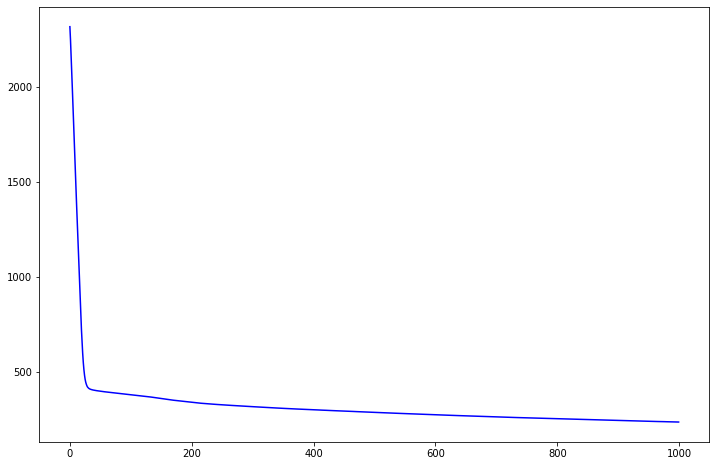

In [119]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

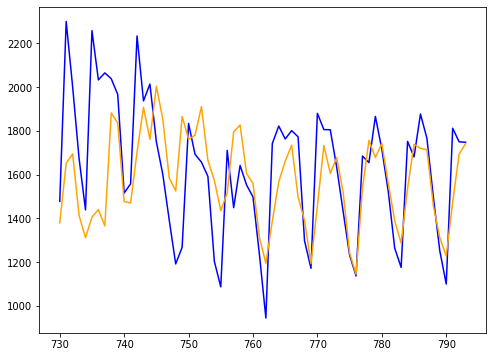

In [121]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(8,6))
plt.plot(time_valid, x_valid, color='blue')
plt.plot(time_valid, results,color='orange');

In [122]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

197.99557

### Simple RNN

In [123]:
window_size = 15
batch_size = 32
shuffle_buffer_size = 1000

In [130]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9)

model.compile(
#               loss=tf.keras.losses.Huber(),
              loss="mse", 
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=40, callbacks=[lr_schedule])

Epoch 1/40
23/23 [==============================] - 1s 62ms/step - loss: 2045020.6997 - mae: 1252.1023
Epoch 2/40
23/23 [==============================] - 0s 14ms/step - loss: 380030.9980 - mae: 488.0378
Epoch 3/40
23/23 [==============================] - 0s 14ms/step - loss: 369581.2643 - mae: 495.7803
Epoch 4/40
23/23 [==============================] - 0s 14ms/step - loss: 360778.0814 - mae: 480.7380
Epoch 5/40
23/23 [==============================] - 0s 14ms/step - loss: 360262.4610 - mae: 483.2677
Epoch 6/40
23/23 [==============================] - 0s 13ms/step - loss: 358755.1755 - mae: 480.7652
Epoch 7/40
23/23 [==============================] - 0s 13ms/step - loss: 358740.9482 - mae: 484.3850
Epoch 8/40
23/23 [==============================] - 0s 14ms/step - loss: 362817.8145 - mae: 480.3419
Epoch 9/40
23/23 [==============================] - 0s 14ms/step - loss: 360133.1951 - mae: 484.0152
Epoch 10/40
23/23 [==============================] - 0s 14ms/step - loss: 356835.9430 - m

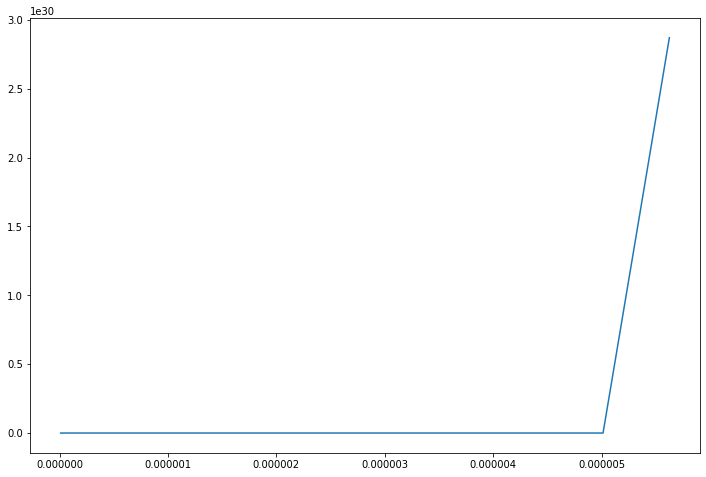

In [125]:
plt.plot(history.history["lr"], history.history["loss"])
# plt.axis([1e-8, 1e-4, 0, 30])

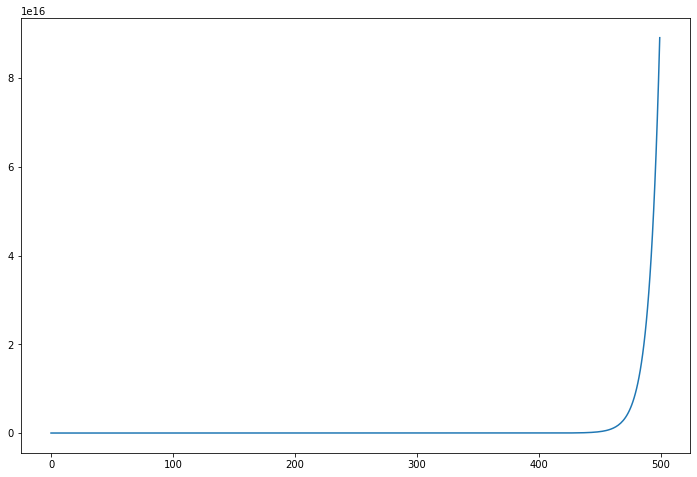

In [126]:
plt.plot(history.history['lr'])

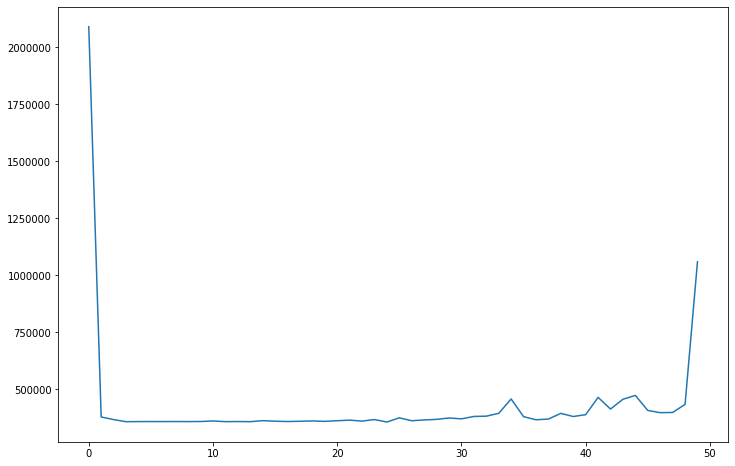

In [129]:
plt.plot(history.history["loss"])

In [24]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

# dataset = windowed_dataset(x_train, window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

# optimizer = tf.keras.optimizers.Adam(lr=1e-8)

model.compile(
#               loss=tf.keras.losses.Huber(),
              loss="mse",
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(dataset,epochs=100, verbose=1)

Epoch 1/100
11/11 [==============================] - 1s 108ms/step - loss: 3984316.5909 - mae: 1945.7843
Epoch 2/100
11/11 [==============================] - 0s 15ms/step - loss: 2843593.2577 - mae: 1611.3413
Epoch 3/100
11/11 [==============================] - 0s 15ms/step - loss: 1954470.2149 - mae: 1320.6497
Epoch 4/100
11/11 [==============================] - 0s 15ms/step - loss: 1276302.6970 - mae: 1034.5354
Epoch 5/100
11/11 [==============================] - 0s 15ms/step - loss: 821340.2776 - mae: 791.6179
Epoch 6/100
11/11 [==============================] - 0s 15ms/step - loss: 517013.9310 - mae: 612.7653
Epoch 7/100
11/11 [==============================] - 0s 15ms/step - loss: 376889.5824 - mae: 494.7413
Epoch 8/100
11/11 [==============================] - 0s 15ms/step - loss: 280390.9921 - mae: 425.0238
Epoch 9/100
11/11 [==============================] - 0s 16ms/step - loss: 241450.6511 - mae: 387.9156
Epoch 10/100
11/11 [==============================] - 0s 15ms/step - loss

11/11 [==============================] - 0s 16ms/step - loss: 192999.4564 - mae: 352.1124
Epoch 81/100
11/11 [==============================] - 0s 16ms/step - loss: 197378.6572 - mae: 352.1055
Epoch 82/100
11/11 [==============================] - ETA: 0s - loss: 209179.2165 - mae: 366.20 - 0s 16ms/step - loss: 197942.7965 - mae: 352.1195
Epoch 83/100
11/11 [==============================] - 0s 15ms/step - loss: 192902.3302 - mae: 352.1158
Epoch 84/100
11/11 [==============================] - 0s 16ms/step - loss: 195352.3145 - mae: 352.1344
Epoch 85/100
11/11 [==============================] - 0s 16ms/step - loss: 195834.8036 - mae: 352.2032
Epoch 86/100
11/11 [==============================] - 0s 16ms/step - loss: 192467.6387 - mae: 352.1188
Epoch 87/100
11/11 [==============================] - 0s 15ms/step - loss: 189641.1615 - mae: 352.1118
Epoch 88/100
11/11 [==============================] - 0s 15ms/step - loss: 195646.8332 - mae: 352.1092
Epoch 89/100
11/11 [======================

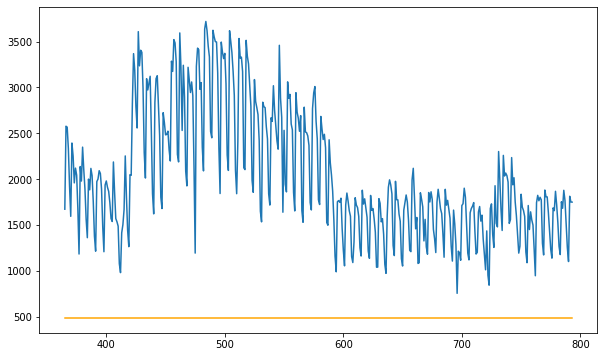

In [21]:
forecast=[]
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plt.plot(time_valid, x_valid)
plt.plot(time_valid, results, color='orange');

### LSTM

In [32]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size=7

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(
#               loss=tf.keras.losses.Huber(),
              loss="mse",
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(dataset, epochs=40, callbacks=[lr_schedule])

Epoch 1/40
12/12 [==============================] - 7s 589ms/step - loss: 4419259.4167 - mae: 2053.7058
Epoch 2/40
12/12 [==============================] - 0s 26ms/step - loss: 3347314.8387 - mae: 1761.5583
Epoch 3/40
12/12 [==============================] - 0s 26ms/step - loss: 1878050.7197 - mae: 1284.3905
Epoch 4/40
12/12 [==============================] - 0s 25ms/step - loss: 593047.9222 - mae: 644.5623
Epoch 5/40
12/12 [==============================] - 0s 26ms/step - loss: 224997.4350 - mae: 372.7026
Epoch 6/40
12/12 [==============================] - 0s 25ms/step - loss: 242520.4674 - mae: 390.6926 0s - loss: 238400.3234 - mae: 390.46
Epoch 7/40
12/12 [==============================] - 0s 26ms/step - loss: 212562.5073 - mae: 363.0599
Epoch 8/40
12/12 [==============================] - 0s 26ms/step - loss: 210521.4463 - mae: 361.8868
Epoch 9/40
12/12 [==============================] - 0s 26ms/step - loss: 210737.7975 - mae: 361.7460
Epoch 10/40
12/12 [============================

[1e-08, 0.0001, 0, 30]

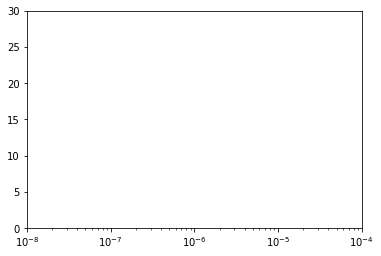

In [33]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [41]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size=15

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
   tf.keras.layers.Dense(1),
   tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=50,verbose=1)

Epoch 1/50
11/11 [==============================] - 9s 812ms/step - loss: 3898275.0000 - mae: 1920.9321
Epoch 2/50
11/11 [==============================] - 0s 34ms/step - loss: 2002035.6387 - mae: 1297.0273
Epoch 3/50
11/11 [==============================] - 0s 32ms/step - loss: 519465.4014 - mae: 596.9193
Epoch 4/50
11/11 [==============================] - 0s 38ms/step - loss: 220559.7390 - mae: 368.4894
Epoch 5/50
11/11 [==============================] - 0s 40ms/step - loss: 246205.2575 - mae: 393.7602
Epoch 6/50
11/11 [==============================] - 0s 32ms/step - loss: 196244.7272 - mae: 354.7158
Epoch 7/50
11/11 [==============================] - 0s 32ms/step - loss: 197217.7292 - mae: 353.5700
Epoch 8/50
11/11 [==============================] - 0s 38ms/step - loss: 192384.1992 - mae: 352.8507
Epoch 9/50
11/11 [==============================] - 0s 40ms/step - loss: 197736.5890 - mae: 352.0615
Epoch 10/50
11/11 [==============================] - 0s 36ms/step - loss: 203326.7078 

<Figure size 720x432 with 0 Axes>

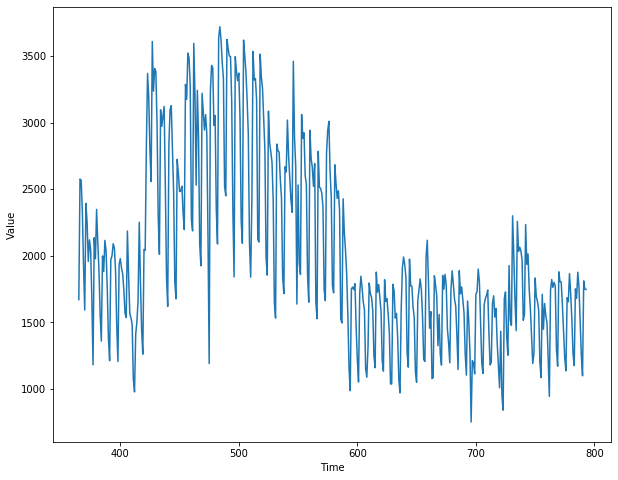

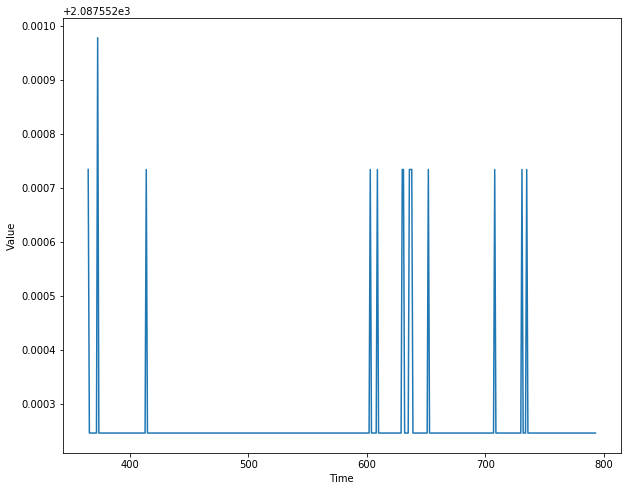

In [39]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

### LSTM with CNN

NEW window function

In [ ]:
# NEW window function
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

#### Combine CNN, LSTM and DNN

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()